# Check Bounding Boxex NIH

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib import patches
from matplotlib.collections import PatchCollection
#import matplotlib
from PIL import Image, ImageDraw
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot
from skimage.color import rgb2gray, gray2rgb
from skimage.filters import threshold_otsu
from shapely.geometry.polygon import Polygon as Polygon_shapley
# from multiprocessing import Pool
import multiprocessing
import time
import random
import pickle
import png
from scipy.spatial import ConvexHull
import bbox_visualizer as bbv
import operator
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder (see the terminal comand below) e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

In the Terminal navigate to the folder you want your data in (**cd** then drag and drop the folder) then enter following:

wget -r -np ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/

(you might need to install wget with **brew install wget** and if you do not have brew then install homebrew https://brew.sh/)


In [2]:
def get_txt(path):
    list_txt = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".txt"):
                txt_path = os.path.join(root, file)
                list_txt.append(txt_path)
    return list_txt


def txt_to_df(path):
    data_file_delimiter = ','
    df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
    root, file = os.path.split(path)
    filename, file_extension = os.path.splitext(file)
    txt_path = os.path.join(root, file)
    img_path = os.path.join(root.replace("GT", "Img"), filename +'.jpg')
    # Loop the data lines
    with open(txt_path, 'r') as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        lines.pop(0)
        for l in lines:
            # Count the column count for the current line
            columns = l.split(data_file_delimiter)
            list_locations = [int(float(location)) for location in columns[5:]]
            zip_locations = list(zip(list_locations[::2], list_locations[1::2]))
            df = df.append( {'Patient no - Cell no': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3], \
                'Number of points': columns[4], 'position': zip_locations, 'filename': filename, 'txt_path': txt_path, 'img_path': img_path}, ignore_index = True)
    return df

def collect_results(df_collected):
    """Uses apply_async's callback to setup up a separate Queue for each process"""
    global df
    df = df.append(df_collected)


In [3]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position, row, rows = 1, columns = 1, i = 1, point_size = 15):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)

    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(row['filename'])

    if annotation == 'Point':
        x = position[0][0] 
        y = position[0][1] 
        cv2.circle(img, position[0], 1, colour, point_size)
    
    elif annotation == 'Polygon':
        if len(position) < 3:
            print('row: ', row)
        if not len(position) < 3:
            poly = Polygon_shapley(position)
            x,y = poly.exterior.xy
            ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)


In [4]:
txt_list = get_txt('../NIH-NLM-ThinBloodSmearsPf')
print(len(txt_list))

965


**The following operation takes a while lean back and get a coffee**

In [5]:
# df = pd.DataFrame(columns = [ 'Patient no - Cell no','cell', 'comment', 'annotation_type','Number of points', 'position', 'filename', 'txt_path', 'img_path'])
# start_time = time.time()  

# # Repeats the compute intensive operation on all available cores
# pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# pool.map_async(txt_to_df, txt_list, callback = collect_results)
# pool.close()
# pool.join()

# # Converts list of lists to a data frame
# print(df.shape)
# print("--- %s seconds ---" % (time.time() - start_time))

In [6]:
# df.reset_index(drop=True, inplace = True)
# pickle_labels = open('labels.pkl', 'wb') 
# pickle.dump(df, pickle_labels)

In [7]:
df = pd.read_pickle('labels.pkl')

In [8]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [9]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected          188711
Parasitized           7952
White_Blood_Cell       271
Name: cell, dtype: int64

In [10]:
df_points = df[df['annotation_type'] == 'Point']
df_points.groupby(['filename']).count()['cell'].mean()

203.3375

In [11]:
# df['position_len'] = df['position'].apply(lambda x: len(x))
# short_polygon = df.loc[(df['annotation_type'] == 'Polygon') & (df['position_len'] < 3)] 
# short_polygon.to_csv('short_polygon.csv', index = False)

In [12]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

In [13]:
df_file[df_file['position'].str.len() > 0]

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

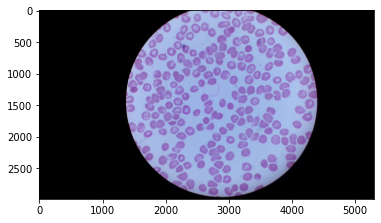

In [14]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
#img = cv2.flip(img, 1)
plt.imshow(img)

In [15]:
# cv2.circle(img, df_file['position'][240][0], 1, (0,255,0), 50)
# plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


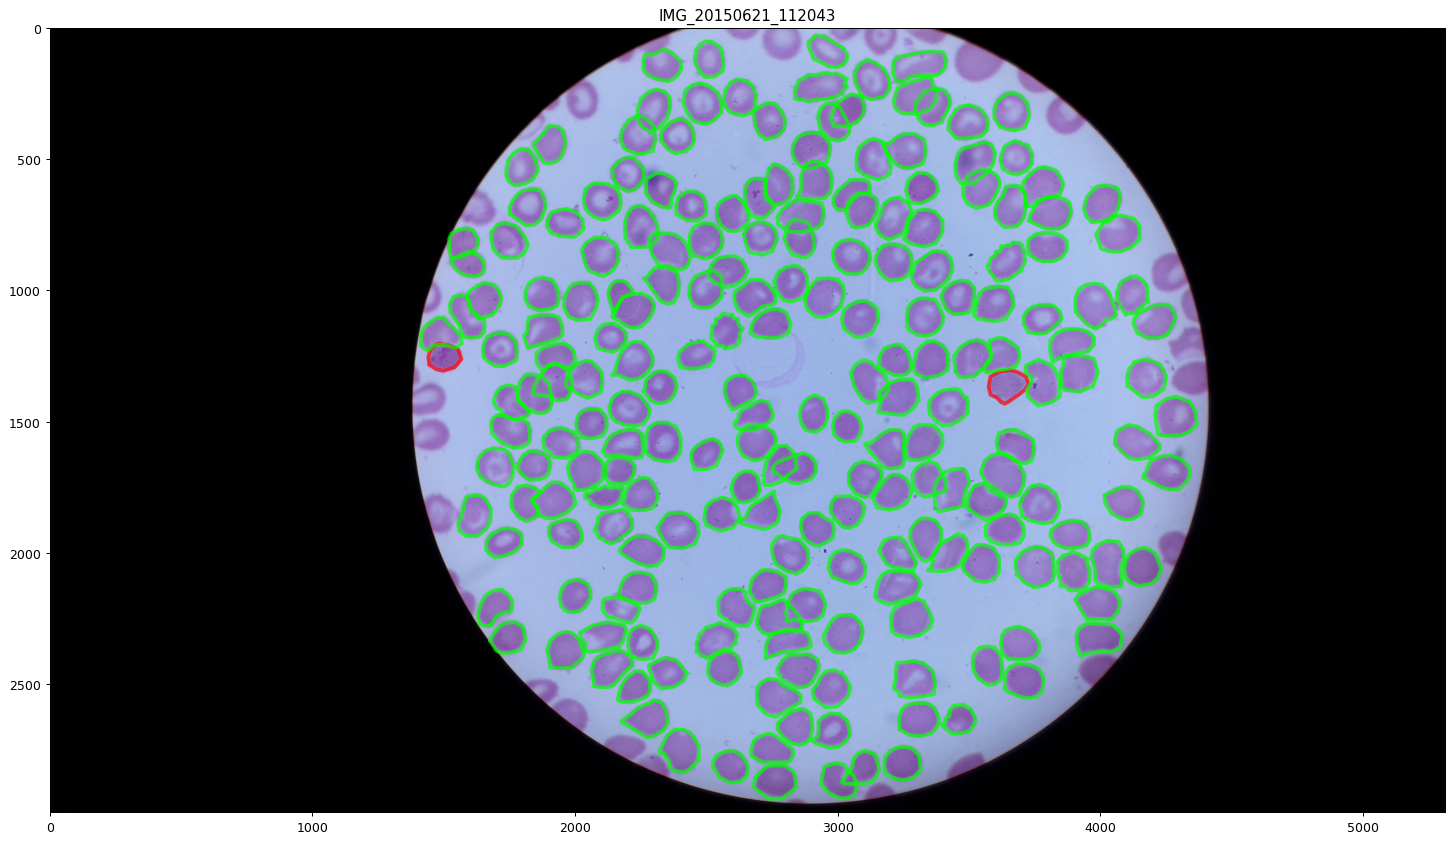

In [16]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row), axis = 1)
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


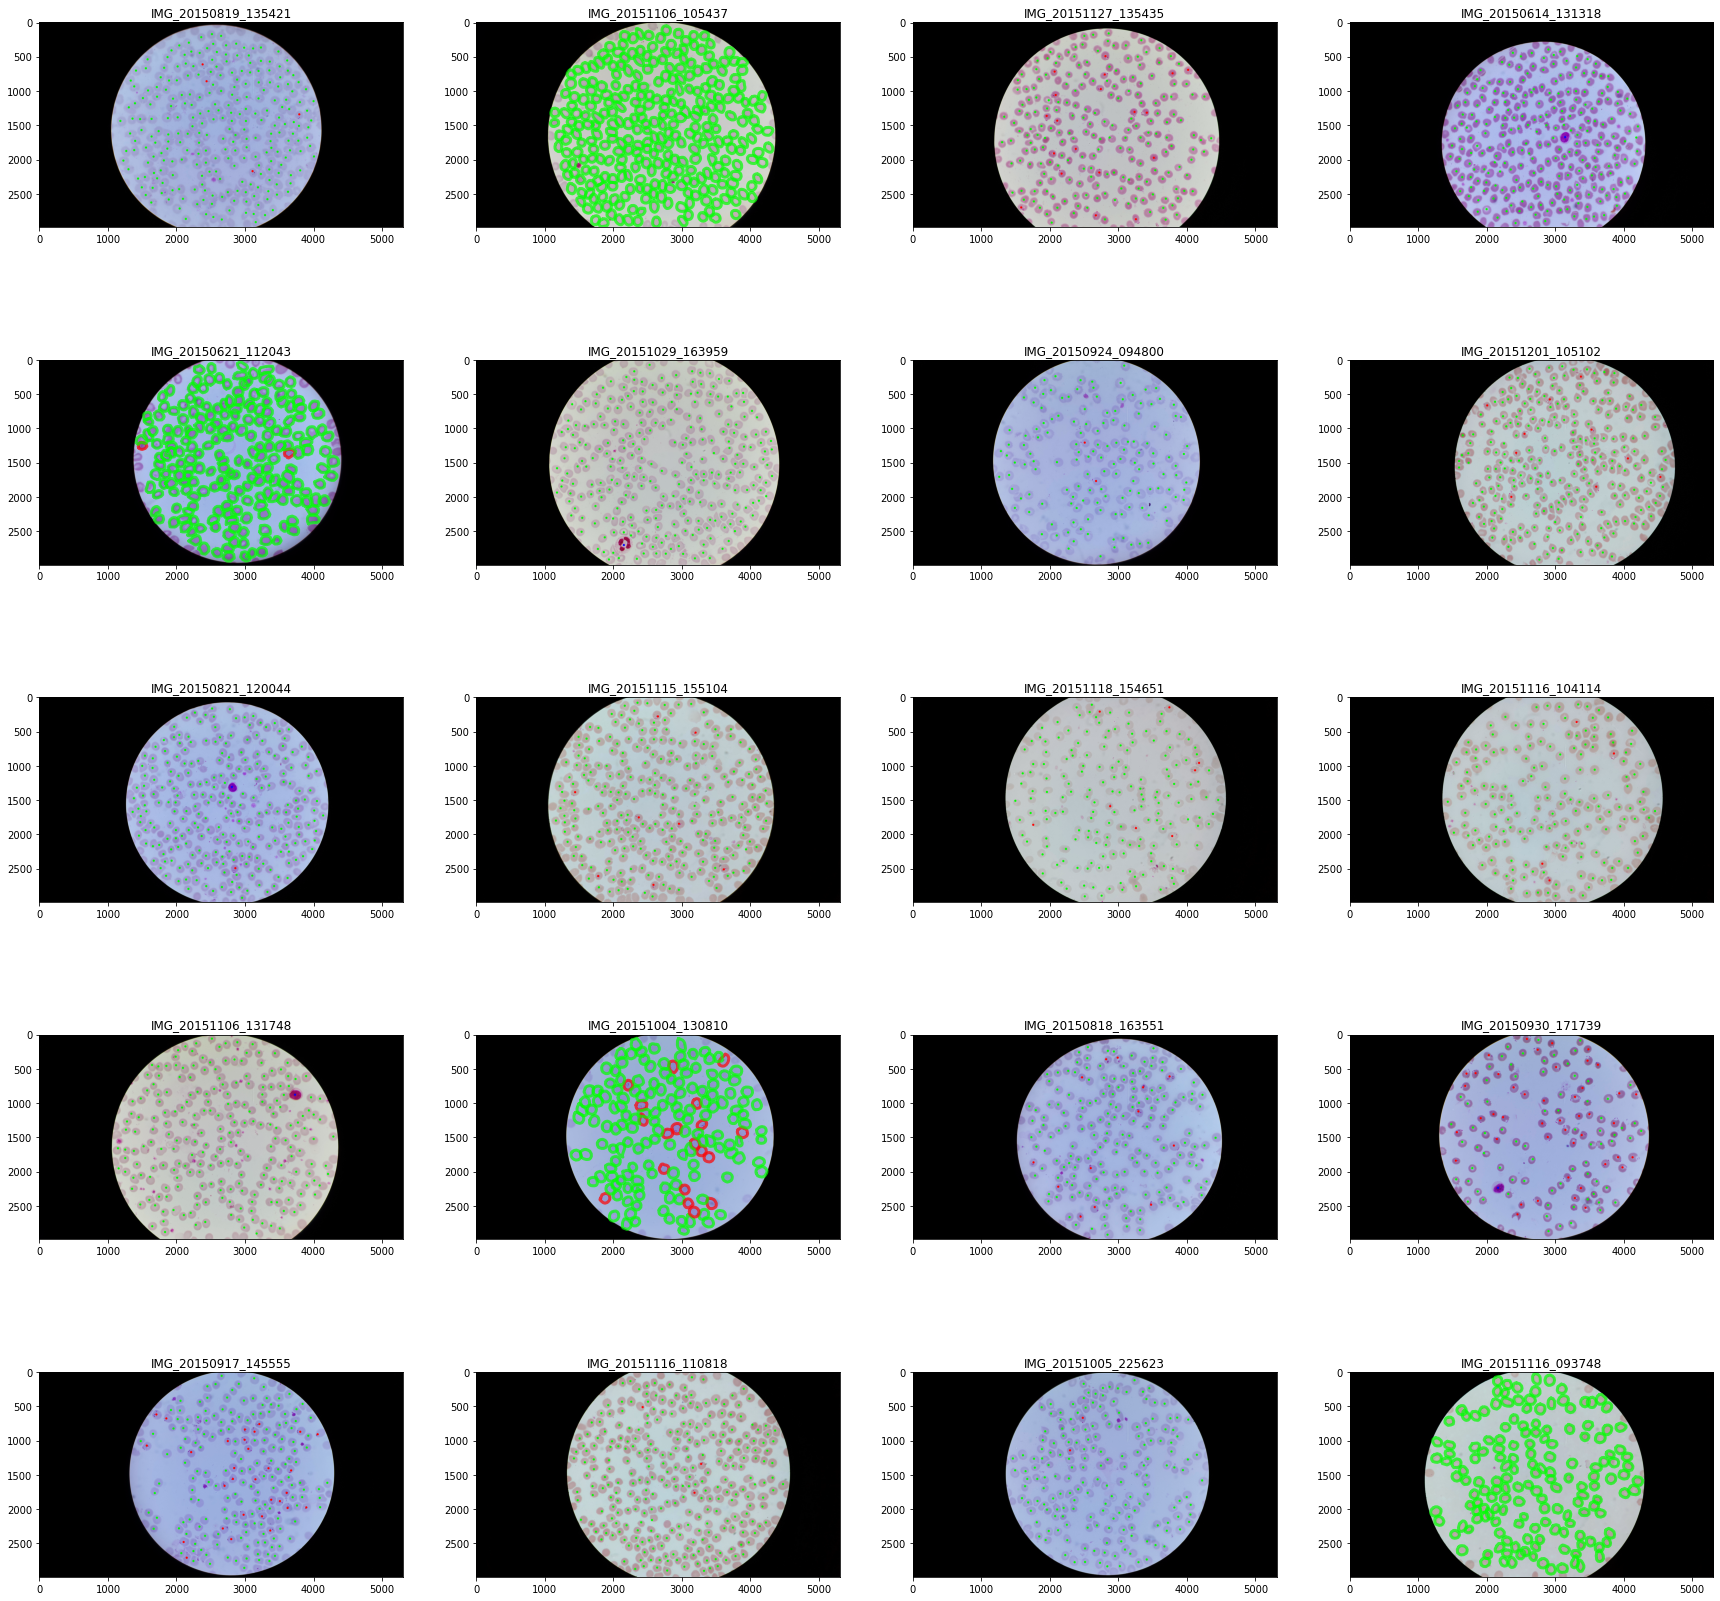

In [17]:
secure_random = random.SystemRandom()

w, h = 10, 10
fig=plt.figure(figsize=(30, 30))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    filename = secure_random.choice(df['filename'].unique())
    df_file = df[df['filename'] == filename]
    #print(filename)
    img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
    df_file.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position'], row = row, rows = rows, columns = columns, i = i, point_size= 30), axis = 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Polygons to mask

In [18]:
def poly_mask(row):
    poly = Polygon(row['position'])
    mask = poly.ravel().tolist()

In [19]:
filename =  'IMG_20151029_162934'

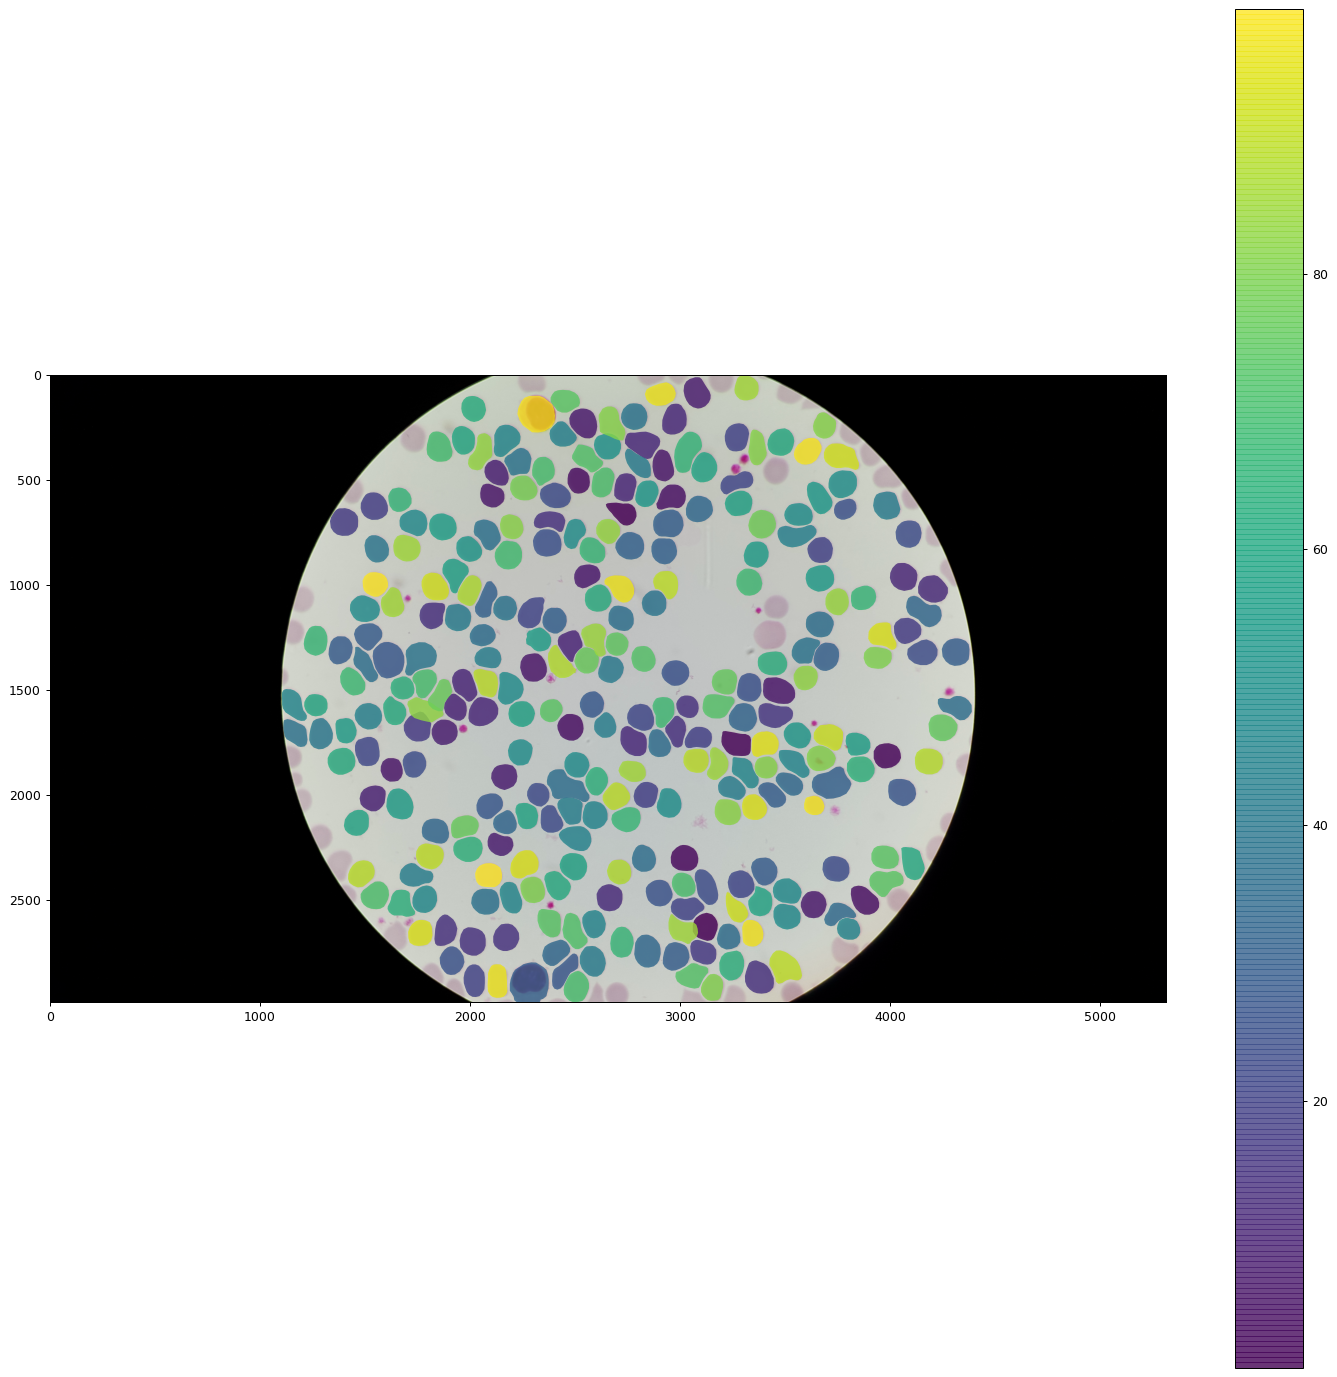

In [20]:
patches = []
patches = [ Polygon(poly) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position'] ]

img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
empty_img = Image.new("L", [img.shape[1], img.shape[0]], 0)
mask = np.array(empty_img)

fig = plt.figure(1, figsize=(20,20), dpi=90)
ax = fig.add_subplot(111)

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.8)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
plt.imshow(img)

image shape:  <PIL.Image.Image image mode=1 size=5312x2988 at 0x7F91D05E97B8>


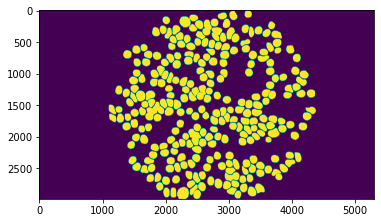

In [21]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)

img = Image.new("L", [img.shape[1], img.shape[0]], 0)
img = img.convert('1')
print('image shape: ', img)
[ ImageDraw.Draw(img).polygon(poly, outline=1, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)

plt.imshow(mask)

img.save('Images/polygon_mask.png')

In [22]:
def poly2mask(filename):
    img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
    img = Image.new("L", [img.shape[1], img.shape[0]], 0)
    img = img.convert('1')
    [ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
    # mask = np.array(img)
    # data = Image.fromarray(mask) 
    # # saving the final output  
    # # as a PNG file 
    # data = data.convert('1')
    # data.save(f'../masks/mask_{filename}.png')
    if not os.path.isdir('../masks'):
        os.makedirs('../masks')

    mask_path = f'../masks/mask_{filename}.png'
    img.save(mask_path)
    return mask, mask_path

In [23]:
filename =  'IMG_20150621_112043' #'IMG_20150623_134547' 
df_file = df[df['filename'] == filename]
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

## Connected Components

In [24]:
def connected_component_label(img):
    # https://iq.opengenus.org/connected-component-labeling/
    # https://stackoverflow.com/questions/13572448/replace-values-of-a-numpy-index-array-with-values-of-a-list


    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    palette = np.arange(1, 179)
    list_rand_nums = np.random.randint(1,179, 179)
    # list_rand_nums gives the new values you wish palette to be mapped to.
    index = np.digitize(label_hue.ravel(), palette, right=True)
    random_hue = np.uint8(list_rand_nums[index].reshape(label_hue.shape))

    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([random_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    plt.imshow(mask)
    plt.axis("off")
    plt.title("Orginal Image")
    plt.show()
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGRA2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    plt.show()

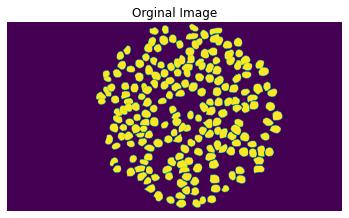

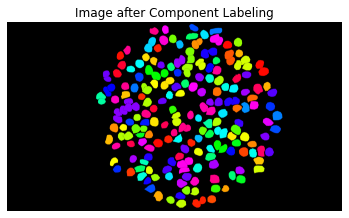

In [25]:
img = cv2.imread(df.loc[(df['annotation_type'] == 'Polygon')  & (df['filename'] == filename), 'img_path'].iloc[-1], cv2.IMREAD_COLOR)
img = Image.new("L", [img.shape[1], img.shape[0]], 0)
#img = img.convert('1')
[ ImageDraw.Draw(img).polygon(poly, outline=0, fill=1) for poly in df.loc[(df['annotation_type'] == 'Polygon') & (df['filename'] == filename), 'position']]
mask = np.array(img)
connected_component_label(mask)

In [26]:
num_labels, labels = cv2.connectedComponents(mask)
print(len(labels[0]))
print(np.max(labels))

5312
175


In [27]:
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...  
...                                                   ...  
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...  

[196934 rows x 9 columns]

In [28]:
def get_bbx(position, annotation_type, bb_pixel):
    if annotation_type == 'Polygon':
        poly_list = np.array([list(ele) for ele in position])
        x_min = np.nanmin(poly_list[:, 0])
        x_max = np.nanmax(poly_list[:, 0])
        y_min = np.nanmin(poly_list[:, 1])
        y_max = np.nanmax(poly_list[:, 1])
        return [x_min, y_min, x_max, y_max]
    if annotation_type == 'Point':
        point_list = np.array(position)
        x_min = int(point_list[:, 0] - 0.5 * bb_pixel)
        x_max = int(point_list[:, 0] + 0.5 * bb_pixel)
        y_min = int(point_list[:, 1] - 0.5 * bb_pixel)
        y_max = int(point_list[:, 1] + 0.5 * bb_pixel)
        return [x_min, y_min, x_max, y_max]

In [29]:
df['bbx'] = df.apply(lambda row: get_bbx(row['position'], row['annotation_type'], 140), axis = 1)
df

Patient no - Cell no         cell     comment annotation_type  \
0                       1-1  Parasitized  No_Comment           Point   
1                       1-2   Uninfected  No_Comment           Point   
2                       1-3   Uninfected  No_Comment           Point   
3                       1-4   Uninfected  No_Comment           Point   
4                       1-5   Uninfected  No_Comment           Point   
...                     ...          ...         ...             ...   
196929                4-167  Parasitized  No_comment         Polygon   
196930                4-168  Parasitized  No_comment         Polygon   
196931                4-169  Parasitized  No_comment         Polygon   
196932                4-170  Parasitized  No_comment         Polygon   
196933                4-171  Parasitized  No_comment         Polygon   

       Number of points                                           position  \
0                     1                                     [(2470, 1302)]   
1                     1                                      [(1598, 944)]   
2                     1                                      [(1756, 987)]   
3                     1                                      [(2000, 895)]   
4                     1                                     [(1938, 1006)]   
...                 ...                                                ...   
196929               25  [(2399, 383), (2404, 363), (2412, 351), (2426,...   
196930               21  [(3522, 2250), (3536, 2230), (3563, 2215), (35...   
196931               20  [(3321, 2138), (3335, 2114), (3347, 2103), (33...   
196932               20  [(3433, 1867), (3441, 1845), (3455, 1831), (34...   
196933               17  [(1432, 1762), (1438, 1739), (1456, 1719), (14...   

                   filename  \
0       IMG_20150918_161508   
1       IMG_20150918_161508   
2       IMG_20150918_161508   
3       IMG_20150918_161508   
4       IMG_20150918_161508   
...                     ...   
196929  IMG_20151004_131030   
196930  IMG_20151004_131030   
196931  IMG_20151004_131030   
196932  IMG_20151004_131030   
196933  IMG_20151004_131030   

                                                 txt_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                                                 img_path  \
0       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
1       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
2       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
3       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
4       ../NIH-NLM-ThinBloodSmearsPf/Point Set/250C102...   
...                                                   ...   
196929  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196930  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196931  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196932  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   
196933  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/276C1...   

                             bbx  
0       [2400, 1232, 2540, 1372]  
1        [1528, 874, 1668, 1014]  
2        [1686, 917, 1826, 1057]  
3         [1930, 825, 2070, 965]  
4        [1868, 936, 2008, 1076]  
...                          ...  
196929    [2389, 328, 2516, 490]  
196930  [3516, 2212, 3675, 2345]  
196931  [3318, 2086, 3469, 2235]  
196932  [3431, 1

## Tiling images and labels

(2988, 5312)


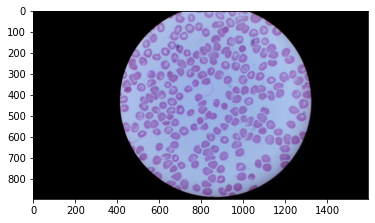

In [30]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
resize_factor = .3
print(img.shape[:2])
resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))), interpolation=cv2.INTER_AREA)
plt.imshow(resized_img)

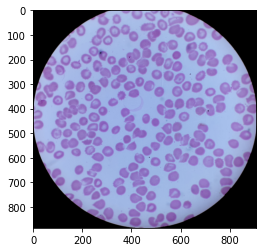

In [31]:
# select circle only
img_gray = rgb2gray(resized_img)
th = threshold_otsu(img_gray)
fg = img_gray>th
# Find the bounding box of those pixels
coords = np.array(np.nonzero(fg))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

#set all under threshhold values to zero 
img_circle = resized_img*gray2rgb(fg)

img_cropped = img_circle[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(img_cropped)

In [32]:
df_file

Patient no - Cell no         cell     comment annotation_type  \
195475                  2-1  Parasitized  No_comment         Polygon   
195476                  2-2  Parasitized  No_comment         Polygon   
195477                  2-3   Uninfected  No_comment         Polygon   
195478                  2-4   Uninfected  No_comment         Polygon   
195479                  2-5   Uninfected  No_comment         Polygon   
...                     ...          ...         ...             ...   
195679                2-205   Uninfected  No_comment         Polygon   
195680                2-206   Uninfected  No_comment         Polygon   
195681                2-207   Uninfected  No_comment         Polygon   
195682                2-208   Uninfected  No_comment         Polygon   
195683                2-209   Uninfected  No_comment         Polygon   

       Number of points                                           position  \
195475               14  [(3624, 1426), (3603, 1407), (3582, 1398), (35...   
195476               11  [(1446, 1284), (1473, 1301), (1498, 1307), (15...   
195477               11  [(2916, 1541), (2951, 1517), (2960, 1491), (29...   
195478               12  [(3007, 1569), (2987, 1551), (2982, 1516), (29...   
195479               10  [(3104, 1788), (3128, 1782), (3166, 1720), (31...   
...                 ...                                                ...   
195679               12  [(3293, 1312), (3289, 1277), (3303, 1227), (33...   
195680               21  [(3351, 1471), (3351, 1454), (3346, 1440), (33...   
195681               12  [(3259, 1631), (3259, 1594), (3271, 1552), (32...   
195682               18  [(3253, 1587), (3253, 1548), (3241, 1534), (32...   
195683               16  [(4166, 1704), (4176, 1688), (4184, 1664), (41...   

                   filename  \
195475  IMG_20150621_112043   
195476  IMG_20150621_112043   
195477  IMG_20150621_112043   
195478  IMG_20150621_112043   
195479  IMG_20150621_112043   
...                     ...   
195679  IMG_20150621_112043   
195680  IMG_20150621_112043   
195681  IMG_20150621_112043   
195682  IMG_20150621_112043   
195683  IMG_20150621_112043   

                                                 txt_path  \
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
...                                                   ...   
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...   

                                                 img_path  
195475  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195476  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195477  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195478  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195479  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
...                                                   ...  
195679  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195680  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195681  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195682  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  
195683  ../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C3...  

[209 rows x 9 columns]

In [33]:
def plot_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)

    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        #print(i)
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            #print(j)
            #print((offset[1]*i, min(offset[1]*i+tile_size[1], img_shape[0])), (offset[0]*j, min(offset[0]*j+tile_size[0], img_shape[1])))
            x_min = min(offset[1] * x + tile_size[1], img_shape[0])
            x_max = offset[1] * x
            y_min = min(offset[0] * y + tile_size[0], img_shape[1])
            y_max = offset[0]*y
            cv2.rectangle(img, (x_max, x_min), (y_max, y_min), (0, 0, 255), 3)
            #cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
            # Debugging the tiles
            #cv2.imwrite("debug_" + str(i) + "_" + str(j) + ".png", cropped_img)
    plt.imshow(crop_img)

def crop_tiles(img, tile_w, tile_h):
    img_shape = img.shape
    tile_size = (tile_w, tile_h)
    offset = (tile_w, tile_h)
    for x in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
        for y in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
            x_min = offset[1] * x
            x_max = min(offset[1] * x + tile_size[1], img_shape[0])
            y_min = offset[0]*y
            y_max = min(offset[0] * y + tile_size[0], img_shape[1])
            crop_image = img[x_min : x_min + tile_w, y_min: y_min + tile_h]
            cv2.imwrite(f'../cropped/{x_min}_{x_max}_{y_min}_{y_max}.png', crop_image) 
    #plt.imshow(crop_image)


In [34]:
crop_tiles(img_cropped, 256, 256)

In [35]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [36]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [37]:
def get_intersection_percent(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        order: [x1, y1, x2, y2] 
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : list
        order: [x1, y1, x2, y2]
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [38]:
get_intersection_percent( [0, 0, 10, 10], [0, 0, 20, 20])

1.0

In [39]:
###############################################################################
def slice_img(input_im, input_mask, 
                     filename,
                    outdir_im, 
                     outdir_mask,
                     outdir_label,
                      classes_dic, 
                     category, 
                     box_coords, resize_factor = 1,
                  sliceHeight=256, sliceWidth=256,
                  zero_frac_thresh=0, overlap=0, pad=0, verbose = False,
                  box_coords_dir='', yolt_coords_dir='', create_mask = False):
    '''
    ADAPTED FROM YOLT/SCRIPTS/SLICE_IM.PY
    Assume input_im is rgb
    Slice large image into smaller pieces,
    ignore slices with a percentage null greater then zero_fract_thresh'''
    if verbose == True:
        print('############# slice_img #############')
    img = cv2.imread(input_im, 1)  # color
    if create_mask:
        mask = cv2.imread(input_mask, 0)
    category_num = [classes_dic[k] for k in category] 

    resized_img = cv2.resize(img, (int(round(img.shape[1] * resize_factor)), int(round(img.shape[0] * resize_factor))))
    if create_mask == True:
        resized_mask = cv2.resize(mask, (int(round(mask.shape[1] * resize_factor)), int(round(mask.shape[0] * resize_factor))))
    resized_box_coords = np.array(np.round(np.array(box_coords) * np.array(resize_factor)).astype(int))


    im_h, im_w = resized_img.shape[:2]
    if verbose:
        print('im_h', im_h)
        print('im_w', im_w)

    win_size = sliceHeight*sliceWidth

    # if slice sizes are large than image, pad the edges
    if sliceHeight > im_h:
        pad = sliceHeight - im_h
    if sliceWidth > im_w:
        pad = max(pad, sliceWidth - im_w)
    # pad the edge of the image with black pixels
    if pad > 0:
        border_color = (0, 0, 0)
        resized_img = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                   cv2.BORDER_CONSTANT, value=border_color)
        if create_mask == True:
            resized_mask = cv2.copyMakeBorder(resized_img, pad, pad, pad, pad,
                                cv2.BORDER_CONSTANT, value=border_color)

    t0 = time.time()
    n_ims = 0
    n_ims_nonull = 0
    dx = int((1. - overlap) * sliceWidth)
    dy = int((1. - overlap) * sliceHeight)
    if verbose:
        print('dx', dx)
        print('dy', dy)
    dict_yolo = {}
    dict_bbx = {}
    max_annot = 0

    for y in range(0, im_h, dy):  # sliceHeight):
        for x in range(0, im_w, dx):  # sliceWidth):
            n_ims += 1
            # extract image
            # make sure we don't go past the edge of the image
            if y + sliceHeight > im_h:
                y0 = im_h - sliceHeight
            else:
                y0 = y
            if x + sliceWidth > im_w:
                x0 = im_w - sliceWidth
            else:
                x0 = x

            window_c = resized_img[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            if create_mask == True:
                window_mask = resized_mask[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
##           gt_c = gt_image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
#             gt_c = image[y0:y0 + sliceHeight, x0:x0 + sliceWidth]
            win_h, win_w = window_c.shape[:2]
    
            outname_part = 'slice_' + filename + \
            '_' + str(y0) + '_' + str(x0) + \
            '_' + str(win_h) + '_' + str(win_w) + \
            '_' + str(pad)

            if create_mask == True:
                outname_mask_part = 'slice_mask_' + filename + \
                    '_' + str(y0) + '_' + str(x0) + \
                    '_' + str(win_h) + '_' + str(win_w) + \
                    '_' + str(pad)
        
            # [x0, x1, y0, y1]


            # get black and white image
            window = cv2.cvtColor(window_c, cv2.COLOR_BGR2GRAY)

            # find threshold of image that's not black
            # https://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html?highlight=threshold
            ret, thresh1 = cv2.threshold(window, 2, 255, cv2.THRESH_BINARY)
            non_zero_counts = cv2.countNonZero(thresh1)
            zero_counts = win_size - non_zero_counts
            zero_frac = float(zero_counts) / win_size
            # print ("zero_frac", zero_fra
            # skip if image is mostly empty
            if zero_frac >= zero_frac_thresh:
                if verbose:
                    print("Zero frac too high at:", zero_frac)
                continue
                
            new_box_coords = []
            yolt_coords = []
            annot_count = 0

            for box, cat in zip(resized_box_coords, category_num):
                cut_box = 0
                percent_in_cut_img = get_intersection_percent(box, [x0, y0, x0 + sliceWidth, y0 + sliceHeight])

                if percent_in_cut_img > 0.75:   
                    resized_box_cat = np.asarray([box[0] - x0, box[1] - y0, box[2] - x0, box[3] - y0, cat])
                    new_box_coords.append(resized_box_cat)
                    annot_count += 1
                    # Input to convert: image size: (w,h), box: [x0, x1, y0, y1]
                    #print(box)
                    yolt_co_i = convert((win_w, win_h), box)
                    yolt_coords.append(yolt_co_i)

                    
            if annot_count > max_annot:
                max_annot = annot_count

            #  save
            outname_im = os.path.join(outdir_im, outname_part + '.png')
            if create_mask == True:
                outname_mask = os.path.join(outdir_mask, outname_mask_part + '.png')
            txt_outpath = os.path.join(outdir_label, outname_part + '.txt')

            dict_yolo[outname_im] = yolt_coords
            dict_bbx[outname_im] = new_box_coords
          

            # save yolt ims
            if verbose:
                print("image output:", outname_im)
            cv2.imwrite(outname_im, window_c)
            if create_mask == True:
                cv2.imwrite(outname_mask, window_mask)

            # save yolt labels
            txt_outfile = open(txt_outpath, "w+")
            if verbose:
                print("txt output:" + txt_outpath)
            for bb in yolt_coords:
                outstring = str(category_num) + " " + \
                    " ".join([str(a) for a in bb]) + '\n'
                if verbose:
                    print("outstring:", outstring)
                txt_outfile.write(outstring)
            txt_outfile.close()

            # if desired, save coords files
            # save box coords dictionary so that yolt_eval.py can read it
            if len(box_coords_dir) > 0:
                coords_dic = gt_dic_from_box_coords(box_coords)
                outname_pkl = os.path.join(
                    box_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(coords_dic, open(outname_pkl, 'wb'), protocol=2)
            if len(yolt_coords_dir) > 0:
                outname_pkl = os.path.join(
                    yolt_coords_dir, outname_part + '_' + category + '.pkl')
                pickle.dump(yolt_coords, open(outname_pkl, 'wb'), protocol=2)

            n_ims_nonull += 1

    if verbose:
        print("Num slices:", n_ims, "Num non-null slices:", n_ims_nonull,
              "sliceHeight", sliceHeight, "sliceWidth", sliceWidth)
        print("Time to slice", input_im, time.time()-t0, "seconds")

    return dict_yolo, dict_bbx, max_annot

def convert(size, box):
    '''Input = image size: (w,h), box: [x0, x1, y0, y1]'''
    dw = 1./size[0]
    dh = 1./size[1]
    xmid = (box[0] + box[1])/2.0
    ymid = (box[2] + box[3])/2.0
    w0 = box[1] - box[0]
    h0 = box[3] - box[2]
    x = xmid*dw
    y = ymid*dh
    w = w0*dw
    h = h0*dh
    return (x, y, w, h)

In [40]:
def cut_images(df,
                slice_height = 256,
                slice_width = 256,
                resize_factor = 0.3,
                classes_dic = {'Uninfected': 0, 'Parasitized': 1, 'White_Blood_Cell': 2},
                zero_frac_thresh = 0.9, 
                overlap = 0, 
                pad = 0,
                verbose=False):
    
    
    dict_mask = {}
    dict_bbxs = {}
    total_max_annot = 0
    mask_path = ''
    outdir_mask = ''

    for filename in df['filename'].unique():
        create_mask = False
        if df.loc[(df['filename'] == filename),'annotation_type'].iloc[-1] ==  'Polygon':
            # first we create a black and white mask where the polygons are white
            mask, mask_path = poly2mask(filename)
            dict_mask[filename] = mask_path
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../cropped'):
                os.makedirs('../cropped')

            outdir_im = f'../cropped/{filename}/img'
            outdir_mask = f'../cropped/{filename}/mask'
            outdir_label = f'../cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_mask = os.path.isdir(outdir_mask)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_mask:
                os.makedirs(outdir_mask)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)
            create_mask = True

        else: 
            # now lets slice the images (and bbx although we will proabaly not use them)
            filename = df.loc[(df['filename'] == filename),'filename'].iloc[-1]
            img_path = df.loc[(df['filename'] == filename),'img_path'].iloc[-1]

            if not os.path.isdir('../cropped'):
                os.makedirs('../cropped')

            outdir_im = f'../cropped/{filename}/img'
            outdir_label = f'../cropped/{filename}/labels'
            check_if_outdir_im = os.path.isdir(outdir_im)
            check_if_outdir_label = os.path.isdir(outdir_label)

            if not check_if_outdir_im:
                os.makedirs(outdir_im)
            if not check_if_outdir_label:
                os.makedirs(outdir_label)


        box_coords = df.loc[(df['filename'] == filename),'bbx'].tolist()
        category = df.loc[(df['filename'] == filename),'cell'].tolist()

        dict_yolo, dict_bbx, \
            max_annot = slice_img(img_path, mask_path, 
                                filename,
                                outdir_im, 
                                outdir_mask, 
                                outdir_label,
                                classes_dic, 
                                category, 
                                box_coords, 
                            sliceHeight= slice_height, sliceWidth=slice_width,
                            resize_factor = resize_factor,
                            zero_frac_thresh = zero_frac_thresh, overlap = overlap, pad = pad, verbose=False,
                            box_coords_dir='', yolt_coords_dir='', create_mask = create_mask)

        if max_annot > total_max_annot:
            total_max_annot = max_annot
            
        dict_bbxs.update(dict_bbx)
            
        print('filename: ', filename, ', len dict_bbx: ', len(dict_bbxs))

    return dict_yolo, dict_bbxs, dict_mask, total_max_annot

In [41]:
#df_para = df.loc[(df['cell'] == 'Parasitized')].reset_index(drop=True)
df_para = df

In [42]:
df.loc[(df['cell'] == 'Parasitized') & (df['filename'] == 'IMG_20151116_110921')]

Patient no - Cell no         cell     comment annotation_type  \
8763                  2-1  Parasitized  No_Comment           Point   
8874                2-112  Parasitized  No_Comment           Point   

     Number of points        position             filename  \
8763                1  [(3338, 2542)]  IMG_20151116_110921   
8874                1  [(2416, 2038)]  IMG_20151116_110921   

                                               txt_path  \
8763  ../NIH-NLM-ThinBloodSmearsPf/Point Set/346C163...   
8874  ../NIH-NLM-ThinBloodSmearsPf/Point Set/346C163...   

                                               img_path  \
8763  ../NIH-NLM-ThinBloodSmearsPf/Point Set/346C163...   
8874  ../NIH-NLM-ThinBloodSmearsPf/Point Set/346C163...   

                           bbx  
8763  [3268, 2472, 3408, 2612]  
8874  [2346, 1968, 2486, 2108]

In [45]:
#dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df_para, classes_dic = {'Parasitized': 1})
dict_yolo, dict_bbxs, dict_mask, total_max_annot = cut_images(df)

filename:  IMG_20150918_161508 , len dict_bbx:  14
filename:  IMG_20150918_162300 , len dict_bbx:  28
filename:  IMG_20150918_162051 , len dict_bbx:  43
filename:  IMG_20150918_161826 , len dict_bbx:  57
filename:  IMG_20150918_162155 , len dict_bbx:  71
filename:  IMG_20151004_111220 , len dict_bbx:  86
filename:  IMG_20151004_111436 , len dict_bbx:  100
filename:  IMG_20151004_111755 , len dict_bbx:  114
filename:  IMG_20151004_111651 , len dict_bbx:  128
filename:  IMG_20151004_111526 , len dict_bbx:  142
filename:  IMG_20151201_163702 , len dict_bbx:  161
filename:  IMG_20151201_164714 , len dict_bbx:  180
filename:  IMG_20151201_165423 , len dict_bbx:  199
filename:  IMG_20151201_163848 , len dict_bbx:  218
filename:  IMG_20151201_163751 , len dict_bbx:  237
filename:  IMG_20151116_101126 , len dict_bbx:  253
filename:  IMG_20151116_100840 , len dict_bbx:  269
filename:  IMG_20151116_100724 , len dict_bbx:  285
filename:  IMG_20151116_101059 , len dict_bbx:  301
filename:  IMG_201

filename:  IMG_20150818_163551 , len dict_bbx:  2521
filename:  IMG_20150818_163419 , len dict_bbx:  2537
filename:  IMG_20150818_164008 , len dict_bbx:  2553
filename:  IMG_20150818_164408 , len dict_bbx:  2569
filename:  IMG_20150818_133307 , len dict_bbx:  2585
filename:  IMG_20150818_132811 , len dict_bbx:  2601
filename:  IMG_20150818_133211 , len dict_bbx:  2617
filename:  IMG_20150818_132918 , len dict_bbx:  2633
filename:  IMG_20150818_133055 , len dict_bbx:  2649
filename:  IMG_20151203_150322 , len dict_bbx:  2668
filename:  IMG_20151203_150132 , len dict_bbx:  2687
filename:  IMG_20151203_150222 , len dict_bbx:  2706
filename:  IMG_20151203_150408 , len dict_bbx:  2725
filename:  IMG_20151203_150557 , len dict_bbx:  2744
filename:  IMG_20150918_172214 , len dict_bbx:  2758
filename:  IMG_20150918_170850 , len dict_bbx:  2772
filename:  IMG_20150918_171154 , len dict_bbx:  2788
filename:  IMG_20150918_171751 , len dict_bbx:  2802
filename:  IMG_20150918_172053 , len dict_bbx:

filename:  IMG_20150728_155921 , len dict_bbx:  5002
filename:  IMG_20150728_160256 , len dict_bbx:  5018
filename:  IMG_20150728_153328 , len dict_bbx:  5034
filename:  IMG_20150728_151330 , len dict_bbx:  5050
filename:  IMG_20151002_123608 , len dict_bbx:  5064
filename:  IMG_20151002_123911 , len dict_bbx:  5078
filename:  IMG_20151002_124304 , len dict_bbx:  5092
filename:  IMG_20151002_123043 , len dict_bbx:  5108
filename:  IMG_20151002_122720 , len dict_bbx:  5122
filename:  IMG_20151106_160304 , len dict_bbx:  5139
filename:  IMG_20151106_160515 , len dict_bbx:  5155
filename:  IMG_20151106_160653 , len dict_bbx:  5171
filename:  IMG_20151106_155857 , len dict_bbx:  5189
filename:  IMG_20151106_160022 , len dict_bbx:  5206
filename:  IMG_20150818_152921 , len dict_bbx:  5223
filename:  IMG_20150818_152613 , len dict_bbx:  5239
filename:  IMG_20150818_152337 , len dict_bbx:  5255
filename:  IMG_20150818_153401 , len dict_bbx:  5271
filename:  IMG_20150818_152455 , len dict_bbx:

filename:  IMG_20151002_125443 , len dict_bbx:  7460
filename:  IMG_20151002_130918 , len dict_bbx:  7474
filename:  IMG_20151002_130407 , len dict_bbx:  7488
filename:  IMG_20151002_130150 , len dict_bbx:  7504
filename:  IMG_20150815_111501 , len dict_bbx:  7519
filename:  IMG_20150815_111302 , len dict_bbx:  7535
filename:  IMG_20150815_111114 , len dict_bbx:  7550
filename:  IMG_20150815_111653 , len dict_bbx:  7564
filename:  IMG_20150815_111422 , len dict_bbx:  7579
filename:  IMG_20150602_111510 , len dict_bbx:  7594
filename:  IMG_20150601_155125 , len dict_bbx:  7609
filename:  IMG_20150601_155642 , len dict_bbx:  7623
filename:  IMG_20150601_152941 , len dict_bbx:  7645
filename:  IMG_20150602_112011 , len dict_bbx:  7661
filename:  IMG_20151201_120845 , len dict_bbx:  7680
filename:  IMG_20151201_121724 , len dict_bbx:  7699
filename:  IMG_20151201_121303 , len dict_bbx:  7718
filename:  IMG_20151201_114035 , len dict_bbx:  7737
filename:  IMG_20151201_121808 , len dict_bbx:

filename:  IMG_20150817_123824 , len dict_bbx:  9924
filename:  IMG_20150817_123500 , len dict_bbx:  9938
filename:  IMG_20150817_123652 , len dict_bbx:  9952
filename:  IMG_20150817_124010 , len dict_bbx:  9967
filename:  IMG_20151127_160539 , len dict_bbx:  9984
filename:  IMG_20151127_160514 , len dict_bbx:  10001
filename:  IMG_20151127_155722 , len dict_bbx:  10018
filename:  IMG_20151127_155914 , len dict_bbx:  10035
filename:  IMG_20151127_160434 , len dict_bbx:  10052
filename:  IMG_20151005_155704 , len dict_bbx:  10068
filename:  IMG_20151005_160256 , len dict_bbx:  10082
filename:  IMG_20151005_160122 , len dict_bbx:  10096
filename:  IMG_20151005_160918 , len dict_bbx:  10110
filename:  IMG_20151005_155444 , len dict_bbx:  10124
filename:  IMG_20150824_105531 , len dict_bbx:  10139
filename:  IMG_20150824_105445 , len dict_bbx:  10154
filename:  IMG_20150824_105213 , len dict_bbx:  10169
filename:  IMG_20150824_110812 , len dict_bbx:  10184
filename:  IMG_20150824_111748 , 

filename:  IMG_20151004_102013 , len dict_bbx:  12345
filename:  IMG_20151004_101929 , len dict_bbx:  12361
filename:  IMG_20150802_122215 , len dict_bbx:  12376
filename:  IMG_20150802_122338 , len dict_bbx:  12391
filename:  IMG_20150802_122648 , len dict_bbx:  12406
filename:  IMG_20150802_122520 , len dict_bbx:  12421
filename:  IMG_20150802_121847 , len dict_bbx:  12436
filename:  IMG_20150917_151320 , len dict_bbx:  12450
filename:  IMG_20150917_145555 , len dict_bbx:  12464
filename:  IMG_20150917_151437 , len dict_bbx:  12478
filename:  IMG_20150917_151512 , len dict_bbx:  12492
filename:  IMG_20150917_150838 , len dict_bbx:  12506
filename:  IMG_20150821_171701 , len dict_bbx:  12522
filename:  IMG_20150821_171603 , len dict_bbx:  12538
filename:  IMG_20150821_171631 , len dict_bbx:  12554
filename:  IMG_20150821_171242 , len dict_bbx:  12570
filename:  IMG_20150821_171530 , len dict_bbx:  12586
filename:  IMG_20151203_141004 , len dict_bbx:  12604
filename:  IMG_20151203_1409

filename:  IMG_20151119_143039 , len dict_bbx:  14758
filename:  IMG_20151119_143212 , len dict_bbx:  14774
filename:  IMG_20151118_163539 , len dict_bbx:  14790
filename:  IMG_20151118_172913 , len dict_bbx:  14806
filename:  IMG_20151118_173039 , len dict_bbx:  14824
filename:  IMG_20150714_093600 , len dict_bbx:  14842
filename:  IMG_20150714_093512 , len dict_bbx:  14860
filename:  IMG_20150714_093715 , len dict_bbx:  14878
filename:  IMG_20150714_093636 , len dict_bbx:  14896
filename:  IMG_20150714_093806 , len dict_bbx:  14914
filename:  IMG_20150724_102330 , len dict_bbx:  14929
filename:  IMG_20150724_103233 , len dict_bbx:  14944
filename:  IMG_20150724_102843 , len dict_bbx:  14959
filename:  IMG_20150724_102951 , len dict_bbx:  14974
filename:  IMG_20150724_103054 , len dict_bbx:  14989
filename:  IMG_20151203_153410 , len dict_bbx:  15008
filename:  IMG_20151203_153713 , len dict_bbx:  15026
filename:  IMG_20151203_154111 , len dict_bbx:  15045
filename:  IMG_20151203_1530

In [46]:
df['mask_path'] = df['filename'].map(dict_mask)

In [47]:
len(dict_bbxs.keys())

15381

In [48]:
# same as above however this time checking for image slice with most parasites

imgs_name = keys = np.array(list(dict_bbxs.keys()))
true_boxes = np.zeros((imgs_name.shape[0], total_max_annot, 5))
print('imgs_name.shape: ', imgs_name.shape)
print('max_annot: ', total_max_annot)
print('true_boxes shape: ', true_boxes.shape)

max_parasitized = {}
            
for key, boxes in dict_bbxs.items():
    count_para = 0
    boxes = np.asarray(boxes)
    idx = int(np.where(imgs_name == key)[0])
    print('boxes shape: ', boxes.shape)
    print('key: ', key)
    print('index in list: ', idx)

    if len(boxes) != 0:
        for box in boxes:
            if box[4] == 1:
                count_para += 1
    max_parasitized[idx] = count_para
    
    if len(boxes) == 0:
        boxes = np.asarray([[0,0,0,0,0]])
    true_boxes[idx, :boxes.shape[0], :5] = boxes

imgs_name.shape:  (15381,)
max_annot:  35
true_boxes shape:  (15381, 35, 5)
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_0_512_256_256_0.png
index in list:  0
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_0_768_256_256_0.png
index in list:  1
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_0_1024_256_256_0.png
index in list:  2
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_256_256_256_256_0.png
index in list:  3
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_256_512_256_256_0.png
index in list:  4
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_256_768_256_256_0.png
index in list:  5
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150918_161508/img/slice_IMG_20150918_161508_256_1024_256_256_0.png
index in list:  6
boxes shape:  (4, 5)
key:  

boxes shape:  (0,)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_512_256_256_256_0.png
index in list:  121
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_512_512_256_256_0.png
index in list:  122
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_512_768_256_256_0.png
index in list:  123
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_512_1024_256_256_0.png
index in list:  124
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_640_512_256_256_0.png
index in list:  125
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_640_768_256_256_0.png
index in list:  126
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151004_111651/img/slice_IMG_20151004_111651_640_1024_256_256_0.png
index in list:  127
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151004_111526/img/slice_IMG_20151004_11152

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_512_256_256_256_0.png
index in list:  309
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_512_512_256_256_0.png
index in list:  310
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_512_768_256_256_0.png
index in list:  311
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_512_1024_256_256_0.png
index in list:  312
boxes shape:  (0,)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_256_256_256_0.png
index in list:  313
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_512_256_256_0.png
index in list:  314
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_640_768_256_256_0.png
index in list:  315
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151116_100959/img/slice_IMG_20151116_100959_6

boxes shape:  (18, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_0_512_256_256_0.png
index in list:  496
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_0_768_256_256_0.png
index in list:  497
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_0_1024_256_256_0.png
index in list:  498
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_0_1280_256_256_0.png
index in list:  499
boxes shape:  (0,)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_0_1338_256_256_0.png
index in list:  500
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_256_256_256_256_0.png
index in list:  501
boxes shape:  (26, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_256_512_256_256_0.png
index in list:  502
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151201_110011/img/slice_IMG_20151201_110011_256_76

boxes shape:  (19, 5)
key:  ../cropped/IMG_20151115_154435/img/slice_IMG_20151115_154435_640_768_256_256_0.png
index in list:  653
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_154435/img/slice_IMG_20151115_154435_640_1024_256_256_0.png
index in list:  654
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_0_512_256_256_0.png
index in list:  655
boxes shape:  (23, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_0_768_256_256_0.png
index in list:  656
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_0_1024_256_256_0.png
index in list:  657
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_256_256_256_256_0.png
index in list:  658
boxes shape:  (24, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818_256_512_256_256_0.png
index in list:  659
boxes shape:  (27, 5)
key:  ../cropped/IMG_20151116_110818/img/slice_IMG_20151116_110818

boxes shape:  (13, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_256_1024_256_256_0.png
index in list:  823
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_512_256_256_256_0.png
index in list:  824
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_512_512_256_256_0.png
index in list:  825
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_512_768_256_256_0.png
index in list:  826
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_512_1024_256_256_0.png
index in list:  827
boxes shape:  (11, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_640_512_256_256_0.png
index in list:  828
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_114153_640_768_256_256_0.png
index in list:  829
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150815_114153/img/slice_IMG_20150815_1

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_256_256_256_0.png
index in list:  1002
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_512_256_256_0.png
index in list:  1003
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_768_256_256_0.png
index in list:  1004
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151115_124032/img/slice_IMG_20151115_124032_640_1024_256_256_0.png
index in list:  1005
boxes shape:  (0,)
key:  ../cropped/IMG_20151115_124557/img/slice_IMG_20151115_124557_0_256_256_256_0.png
index in list:  1006
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_124557/img/slice_IMG_20151115_124557_0_512_256_256_0.png
index in list:  1007
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_124557/img/slice_IMG_20151115_124557_0_768_256_256_0.png
index in list:  1008
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151115_124557/img/slice_IMG_20151115_12455

boxes shape:  (26, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_768_256_256_0.png
index in list:  1185
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_256_1024_256_256_0.png
index in list:  1186
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_512_256_256_256_0.png
index in list:  1187
boxes shape:  (26, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_512_512_256_256_0.png
index in list:  1188
boxes shape:  (26, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_512_768_256_256_0.png
index in list:  1189
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_512_1024_256_256_0.png
index in list:  1190
boxes shape:  (0,)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150820_110040_640_256_256_256_0.png
index in list:  1191
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150820_110040/img/slice_IMG_20150

boxes shape:  (20, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_0_768_256_256_0.png
index in list:  1366
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_0_1024_256_256_0.png
index in list:  1367
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_256_256_256_256_0.png
index in list:  1368
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_256_512_256_256_0.png
index in list:  1369
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_256_768_256_256_0.png
index in list:  1370
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_256_1024_256_256_0.png
index in list:  1371
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_20150815_104923_512_256_256_256_0.png
index in list:  1372
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150815_104923/img/slice_IMG_2015081

boxes shape:  (21, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_512_768_256_256_0.png
index in list:  1537
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_512_1024_256_256_0.png
index in list:  1538
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_512_1280_256_256_0.png
index in list:  1539
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_640_256_256_256_0.png
index in list:  1540
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_640_512_256_256_0.png
index in list:  1541
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_640_768_256_256_0.png
index in list:  1542
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151127_115545/img/slice_IMG_20151127_115545_640_1024_256_256_0.png
index in list:  1543
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150930_102716/img/slice_IMG_201

boxes shape:  (5, 5)
key:  ../cropped/IMG_20150918_144348/img/slice_IMG_20150918_144348_512_1024_256_256_0.png
index in list:  1718
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150918_144348/img/slice_IMG_20150918_144348_640_512_256_256_0.png
index in list:  1719
boxes shape:  (11, 5)
key:  ../cropped/IMG_20150918_144348/img/slice_IMG_20150918_144348_640_768_256_256_0.png
index in list:  1720
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150918_144348/img/slice_IMG_20150918_144348_640_1024_256_256_0.png
index in list:  1721
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_0_512_256_256_0.png
index in list:  1722
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_0_768_256_256_0.png
index in list:  1723
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150918_144823/img/slice_IMG_20150918_144823_0_1024_256_256_0.png
index in list:  1724
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150918_144823/img/slice_IMG_20150918_14

boxes shape:  (20, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_0_768_256_256_0.png
index in list:  1893
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_0_1024_256_256_0.png
index in list:  1894
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_256_256_256_256_0.png
index in list:  1895
boxes shape:  (25, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_256_512_256_256_0.png
index in list:  1896
boxes shape:  (26, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_256_768_256_256_0.png
index in list:  1897
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_256_1024_256_256_0.png
index in list:  1898
boxes shape:  (0,)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_151722_256_1280_256_256_0.png
index in list:  1899
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150821_151722/img/slice_IMG_20150821_

boxes shape:  (10, 5)
key:  ../cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_512_1024_256_256_0.png
index in list:  2069
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_640_256_256_256_0.png
index in list:  2070
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_640_512_256_256_0.png
index in list:  2071
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_640_768_256_256_0.png
index in list:  2072
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150930_113003/img/slice_IMG_20150930_113003_640_1024_256_256_0.png
index in list:  2073
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_0_512_256_256_0.png
index in list:  2074
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151119_120111/img/slice_IMG_20151119_120111_0_768_256_256_0.png
index in list:  2075
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151119_120111/img/slice_IMG_2015111

boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_256_512_256_256_0.png
index in list:  2251
boxes shape:  (26, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_256_768_256_256_0.png
index in list:  2252
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_256_1024_256_256_0.png
index in list:  2253
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_256_1280_256_256_0.png
index in list:  2254
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_512_256_256_256_0.png
index in list:  2255
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_512_512_256_256_0.png
index in list:  2256
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20151112_160129_512_768_256_256_0.png
index in list:  2257
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151112_160129/img/slice_IMG_20

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_256_256_256_0.png
index in list:  2419
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_512_256_256_0.png
index in list:  2420
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_768_256_256_0.png
index in list:  2421
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_1024_256_256_0.png
index in list:  2422
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_1280_256_256_0.png
index in list:  2423
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_512_1338_256_256_0.png
index in list:  2424
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_20151130_115733_640_512_256_256_0.png
index in list:  2425
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151130_115733/img/slice_IMG_201

boxes shape:  (13, 5)
key:  ../cropped/IMG_20150818_132811/img/slice_IMG_20150818_132811_640_512_256_256_0.png
index in list:  2598
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150818_132811/img/slice_IMG_20150818_132811_640_768_256_256_0.png
index in list:  2599
boxes shape:  (11, 5)
key:  ../cropped/IMG_20150818_132811/img/slice_IMG_20150818_132811_640_1024_256_256_0.png
index in list:  2600
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_0_512_256_256_0.png
index in list:  2601
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_0_768_256_256_0.png
index in list:  2602
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_0_1024_256_256_0.png
index in list:  2603
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150818_133211/img/slice_IMG_20150818_133211_256_256_256_256_0.png
index in list:  2604
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150818_133211/img/slice_IMG_20150818

boxes shape:  (10, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_0_1024_256_256_0.png
index in list:  2775
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_256_256_256_256_0.png
index in list:  2776
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_256_512_256_256_0.png
index in list:  2777
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_256_768_256_256_0.png
index in list:  2778
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_256_1024_256_256_0.png
index in list:  2779
boxes shape:  (0,)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_256_1280_256_256_0.png
index in list:  2780
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_20150918_171154_512_256_256_256_0.png
index in list:  2781
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150918_171154/img/slice_IMG_2015091

boxes shape:  (20, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_256_768_256_256_0.png
index in list:  2957
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_256_1024_256_256_0.png
index in list:  2958
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_512_256_256_256_0.png
index in list:  2959
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_512_512_256_256_0.png
index in list:  2960
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_512_768_256_256_0.png
index in list:  2961
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_512_1024_256_256_0.png
index in list:  2962
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20151005_123715_640_512_256_256_0.png
index in list:  2963
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151005_123715/img/slice_IMG_20

index in list:  3137
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_256_256_256_0.png
index in list:  3138
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_512_256_256_0.png
index in list:  3139
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_768_256_256_0.png
index in list:  3140
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_512_1024_256_256_0.png
index in list:  3141
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_256_256_256_0.png
index in list:  3142
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_512_256_256_0.png
index in list:  3143
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151106_154510/img/slice_IMG_20151106_154510_640_768_256_256_0.png
index in list:  3144
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151106_154

boxes shape:  (4, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_0_1024_256_256_0.png
index in list:  3332
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_256_256_256_0.png
index in list:  3333
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_512_256_256_0.png
index in list:  3334
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_768_256_256_0.png
index in list:  3335
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_256_1024_256_256_0.png
index in list:  3336
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_256_256_256_0.png
index in list:  3337
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_20150930_171635_512_512_256_256_0.png
index in list:  3338
boxes shape:  (11, 5)
key:  ../cropped/IMG_20150930_171635/img/slice_IMG_201509

boxes shape:  (3, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_256_1280_256_256_0.png
index in list:  3506
boxes shape:  (0,)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_256_1338_256_256_0.png
index in list:  3507
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_512_256_256_256_0.png
index in list:  3508
boxes shape:  (26, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_512_512_256_256_0.png
index in list:  3509
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_512_768_256_256_0.png
index in list:  3510
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_512_1024_256_256_0.png
index in list:  3511
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_20151203_110933_512_1280_256_256_0.png
index in list:  3512
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151203_110933/img/slice_IMG_201512

boxes shape:  (19, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_512_512_256_256_0.png
index in list:  3678
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_512_768_256_256_0.png
index in list:  3679
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_512_1024_256_256_0.png
index in list:  3680
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_640_256_256_256_0.png
index in list:  3681
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_640_512_256_256_0.png
index in list:  3682
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_640_768_256_256_0.png
index in list:  3683
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151115_120244/img/slice_IMG_20151115_120244_640_1024_256_256_0.png
index in list:  3684
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151115_115950/img/slice_IMG_201

boxes shape:  (6, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_0_512_256_256_0.png
index in list:  3862
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_0_768_256_256_0.png
index in list:  3863
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_0_1024_256_256_0.png
index in list:  3864
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_256_256_256_0.png
index in list:  3865
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_512_256_256_0.png
index in list:  3866
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_768_256_256_0.png
index in list:  3867
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_154050_256_1024_256_256_0.png
index in list:  3868
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150818_154050/img/slice_IMG_20150818_15

boxes shape:  (19, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_256_1024_256_256_0.png
index in list:  4046
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_256_1280_256_256_0.png
index in list:  4047
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_512_512_256_256_0.png
index in list:  4048
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_512_768_256_256_0.png
index in list:  4049
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_512_1024_256_256_0.png
index in list:  4050
boxes shape:  (0,)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_512_1280_256_256_0.png
index in list:  4051
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_20150622_105102_640_512_256_256_0.png
index in list:  4052
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150622_105102/img/slice_IMG_2015

boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_512_1024_256_256_0.png
index in list:  4228
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_256_256_256_0.png
index in list:  4229
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_512_256_256_0.png
index in list:  4230
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_768_256_256_0.png
index in list:  4231
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151106_144143/img/slice_IMG_20151106_144143_640_1024_256_256_0.png
index in list:  4232
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151106_143940/img/slice_IMG_20151106_143940_0_256_256_256_0.png
index in list:  4233
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151106_143940/img/slice_IMG_20151106_143940_0_512_256_256_0.png
index in list:  4234
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151106_143940/img/slice_IMG_2015110

boxes shape:  (23, 5)
key:  ../cropped/IMG_20151112_113803/img/slice_IMG_20151112_113803_512_1024_256_256_0.png
index in list:  4411
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151112_113803/img/slice_IMG_20151112_113803_640_256_256_256_0.png
index in list:  4412
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_113803/img/slice_IMG_20151112_113803_640_512_256_256_0.png
index in list:  4413
boxes shape:  (26, 5)
key:  ../cropped/IMG_20151112_113803/img/slice_IMG_20151112_113803_640_768_256_256_0.png
index in list:  4414
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151112_113803/img/slice_IMG_20151112_113803_640_1024_256_256_0.png
index in list:  4415
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_0_512_256_256_0.png
index in list:  4416
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151201_172057/img/slice_IMG_20151201_172057_0_768_256_256_0.png
index in list:  4417
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151201_172057/img/slice_IMG_2015120

boxes shape:  (3, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_0_1024_256_256_0.png
index in list:  4599
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_256_256_256_256_0.png
index in list:  4600
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_256_512_256_256_0.png
index in list:  4601
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_256_768_256_256_0.png
index in list:  4602
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_256_1024_256_256_0.png
index in list:  4603
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_512_256_256_256_0.png
index in list:  4604
boxes shape:  (4, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_151335_512_512_256_256_0.png
index in list:  4605
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150918_151335/img/slice_IMG_20150918_1

boxes shape:  (13, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_0_512_256_256_0.png
index in list:  4780
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_0_768_256_256_0.png
index in list:  4781
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_0_1024_256_256_0.png
index in list:  4782
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_256_256_256_256_0.png
index in list:  4783
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_256_512_256_256_0.png
index in list:  4784
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_256_768_256_256_0.png
index in list:  4785
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_141913_256_1024_256_256_0.png
index in list:  4786
boxes shape:  (4, 5)
key:  ../cropped/IMG_20150820_141913/img/slice_IMG_20150820_1

boxes shape:  (17, 5)
key:  ../cropped/IMG_20151029_155436/img/slice_IMG_20151029_155436_640_768_256_256_0.png
index in list:  4951
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151029_155436/img/slice_IMG_20151029_155436_640_1024_256_256_0.png
index in list:  4952
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155554_0_256_256_256_0.png
index in list:  4953
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155554_0_512_256_256_0.png
index in list:  4954
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155554_0_768_256_256_0.png
index in list:  4955
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155554_0_1024_256_256_0.png
index in list:  4956
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155554_256_256_256_256_0.png
index in list:  4957
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151029_155554/img/slice_IMG_20151029_155

boxes shape:  (16, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_256_1024_256_256_0.png
index in list:  5129
boxes shape:  (0,)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_256_1280_256_256_0.png
index in list:  5130
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_512_256_256_256_0.png
index in list:  5131
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_512_512_256_256_0.png
index in list:  5132
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_512_768_256_256_0.png
index in list:  5133
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_512_1024_256_256_0.png
index in list:  5134
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_20151106_160304_640_256_256_256_0.png
index in list:  5135
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151106_160304/img/slice_IMG_2015

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_0_1024_256_256_0.png
index in list:  5306
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_256_256_256_256_0.png
index in list:  5307
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_256_512_256_256_0.png
index in list:  5308
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_256_768_256_256_0.png
index in list:  5309
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_256_1024_256_256_0.png
index in list:  5310
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_512_256_256_256_0.png
index in list:  5311
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_20151115_162818_512_512_256_256_0.png
index in list:  5312
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151115_162818/img/slice_IMG_201511

boxes shape:  (15, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_1024_256_256_0.png
index in list:  5477
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_1280_256_256_0.png
index in list:  5478
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_256_1338_256_256_0.png
index in list:  5479
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_512_256_256_256_0.png
index in list:  5480
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_512_512_256_256_0.png
index in list:  5481
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_512_768_256_256_0.png
index in list:  5482
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20151130_160135_512_1024_256_256_0.png
index in list:  5483
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151130_160135/img/slice_IMG_20

boxes shape:  (3, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_0_768_256_256_0.png
index in list:  5651
boxes shape:  (4, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_0_1024_256_256_0.png
index in list:  5652
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_256_256_256_256_0.png
index in list:  5653
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_256_512_256_256_0.png
index in list:  5654
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_256_768_256_256_0.png
index in list:  5655
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_256_1024_256_256_0.png
index in list:  5656
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_101257_256_1280_256_256_0.png
index in list:  5657
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150818_101257/img/slice_IMG_20150818_10

boxes shape:  (6, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_0_256_256_256_0.png
index in list:  5816
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_0_512_256_256_0.png
index in list:  5817
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_0_768_256_256_0.png
index in list:  5818
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_0_1024_256_256_0.png
index in list:  5819
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_256_256_256_256_0.png
index in list:  5820
boxes shape:  (24, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_256_512_256_256_0.png
index in list:  5821
boxes shape:  (28, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_160529_256_768_256_256_0.png
index in list:  5822
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151015_160529/img/slice_IMG_20151015_16

boxes shape:  (7, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_256_1024_256_256_0.png
index in list:  5986
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_512_256_256_256_0.png
index in list:  5987
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_512_512_256_256_0.png
index in list:  5988
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_512_768_256_256_0.png
index in list:  5989
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_512_1024_256_256_0.png
index in list:  5990
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_640_512_256_256_0.png
index in list:  5991
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_20151005_214033_640_768_256_256_0.png
index in list:  5992
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151005_214033/img/slice_IMG_2015100

key:  ../cropped/IMG_20151106_114910/img/slice_IMG_20151106_114910_640_768_256_256_0.png
index in list:  6149
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151106_114910/img/slice_IMG_20151106_114910_640_1024_256_256_0.png
index in list:  6150
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_0_256_256_256_0.png
index in list:  6151
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_0_512_256_256_0.png
index in list:  6152
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_0_768_256_256_0.png
index in list:  6153
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_0_1024_256_256_0.png
index in list:  6154
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_256_256_256_256_0.png
index in list:  6155
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_131748/img/slice_IMG_20151106_131748_256_512_256_256_0

boxes shape:  (11, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_0_512_256_256_0.png
index in list:  6320
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_0_768_256_256_0.png
index in list:  6321
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_0_1024_256_256_0.png
index in list:  6322
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_256_256_256_256_0.png
index in list:  6323
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_256_512_256_256_0.png
index in list:  6324
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_256_768_256_256_0.png
index in list:  6325
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_152257_256_1024_256_256_0.png
index in list:  6326
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151004_152257/img/slice_IMG_20151004_1

boxes shape:  (14, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_256_1024_256_256_0.png
index in list:  6483
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_512_256_256_256_0.png
index in list:  6484
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_512_512_256_256_0.png
index in list:  6485
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_512_768_256_256_0.png
index in list:  6486
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_512_1024_256_256_0.png
index in list:  6487
boxes shape:  (4, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_640_256_256_256_0.png
index in list:  6488
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_20150930_134355_640_512_256_256_0.png
index in list:  6489
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150930_134355/img/slice_IMG_2015

boxes shape:  (7, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_512_256_256_256_0.png
index in list:  6643
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_512_512_256_256_0.png
index in list:  6644
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_512_768_256_256_0.png
index in list:  6645
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_512_1024_256_256_0.png
index in list:  6646
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_256_256_256_0.png
index in list:  6647
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_512_256_256_0.png
index in list:  6648
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_20151115_190642_640_768_256_256_0.png
index in list:  6649
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151115_190642/img/slice_IMG_2015

boxes shape:  (9, 5)
key:  ../cropped/IMG_20151002_154846/img/slice_IMG_20151002_154846_640_1024_256_256_0.png
index in list:  6809
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_0_512_256_256_0.png
index in list:  6810
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_0_768_256_256_0.png
index in list:  6811
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_0_1024_256_256_0.png
index in list:  6812
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_256_256_256_256_0.png
index in list:  6813
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_256_512_256_256_0.png
index in list:  6814
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_155026_256_768_256_256_0.png
index in list:  6815
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151002_155026/img/slice_IMG_20151002_1

boxes shape:  (27, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_256_512_256_256_0.png
index in list:  6983
boxes shape:  (28, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_256_768_256_256_0.png
index in list:  6984
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_256_1024_256_256_0.png
index in list:  6985
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_512_256_256_256_0.png
index in list:  6986
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_512_512_256_256_0.png
index in list:  6987
boxes shape:  (28, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_512_768_256_256_0.png
index in list:  6988
boxes shape:  (25, 5)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150614_131529_512_1024_256_256_0.png
index in list:  6989
boxes shape:  (0,)
key:  ../cropped/IMG_20150614_131529/img/slice_IMG_20150

boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_256_1024_256_256_0.png
index in list:  7174
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_256_256_256_0.png
index in list:  7175
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_512_256_256_0.png
index in list:  7176
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_768_256_256_0.png
index in list:  7177
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_512_1024_256_256_0.png
index in list:  7178
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_640_256_256_256_0.png
index in list:  7179
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20151115_112253_640_512_256_256_0.png
index in list:  7180
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151115_112253/img/slice_IMG_20

boxes shape:  (10, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_512_256_256_256_0.png
index in list:  7364
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_512_512_256_256_0.png
index in list:  7365
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_512_768_256_256_0.png
index in list:  7366
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_512_1024_256_256_0.png
index in list:  7367
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_640_256_256_256_0.png
index in list:  7368
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_640_512_256_256_0.png
index in list:  7369
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_20150608_162835_640_768_256_256_0.png
index in list:  7370
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150608_162835/img/slice_IMG_201

boxes shape:  (18, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_0_768_256_256_0.png
index in list:  7537
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_0_1024_256_256_0.png
index in list:  7538
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_256_256_256_256_0.png
index in list:  7539
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_256_512_256_256_0.png
index in list:  7540
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_256_768_256_256_0.png
index in list:  7541
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_256_1024_256_256_0.png
index in list:  7542
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815_111114_512_256_256_256_0.png
index in list:  7543
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150815_111114/img/slice_IMG_20150815

boxes shape:  (11, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_256_1024_256_256_0.png
index in list:  7725
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_256_1280_256_256_0.png
index in list:  7726
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_256_1338_256_256_0.png
index in list:  7727
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_512_512_256_256_0.png
index in list:  7728
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_512_768_256_256_0.png
index in list:  7729
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_512_1024_256_256_0.png
index in list:  7730
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20151201_114035_512_1280_256_256_0.png
index in list:  7731
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151201_114035/img/slice_IMG_20

boxes shape:  (0,)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_256_1280_256_256_0.png
index in list:  7904
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_512_256_256_256_0.png
index in list:  7905
boxes shape:  (25, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_512_512_256_256_0.png
index in list:  7906
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_512_768_256_256_0.png
index in list:  7907
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_512_1024_256_256_0.png
index in list:  7908
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_640_256_256_256_0.png
index in list:  7909
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151112_150329_640_512_256_256_0.png
index in list:  7910
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151112_150329/img/slice_IMG_20151

boxes shape:  (3, 5)
key:  ../cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_640_256_256_256_0.png
index in list:  8078
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_640_512_256_256_0.png
index in list:  8079
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_640_768_256_256_0.png
index in list:  8080
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151115_143051/img/slice_IMG_20151115_143051_640_1024_256_256_0.png
index in list:  8081
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151115_142836/img/slice_IMG_20151115_142836_0_256_256_256_0.png
index in list:  8082
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151115_142836/img/slice_IMG_20151115_142836_0_512_256_256_0.png
index in list:  8083
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_142836/img/slice_IMG_20151115_142836_0_768_256_256_0.png
index in list:  8084
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151115_142836/img/slice_IMG_20151115_142

boxes shape:  (7, 5)
key:  ../cropped/IMG_20151106_141500/img/slice_IMG_20151106_141500_640_256_256_256_0.png
index in list:  8260
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151106_141500/img/slice_IMG_20151106_141500_640_512_256_256_0.png
index in list:  8261
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151106_141500/img/slice_IMG_20151106_141500_640_768_256_256_0.png
index in list:  8262
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151106_141500/img/slice_IMG_20151106_141500_640_1024_256_256_0.png
index in list:  8263
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151106_141649/img/slice_IMG_20151106_141649_0_256_256_256_0.png
index in list:  8264
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151106_141649/img/slice_IMG_20151106_141649_0_512_256_256_0.png
index in list:  8265
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_141649/img/slice_IMG_20151106_141649_0_768_256_256_0.png
index in list:  8266
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151106_141649/img/slice_IMG_20151106_14

boxes shape:  (10, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_0_1024_256_256_0.png
index in list:  8435
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_256_256_256_0.png
index in list:  8436
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_512_256_256_0.png
index in list:  8437
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_768_256_256_0.png
index in list:  8438
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_1024_256_256_0.png
index in list:  8439
boxes shape:  (0,)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_256_1280_256_256_0.png
index in list:  8440
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_20151112_104410_512_256_256_256_0.png
index in list:  8441
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151112_104410/img/slice_IMG_201511

boxes shape:  (22, 5)
key:  ../cropped/IMG_20151115_114910/img/slice_IMG_20151115_114910_640_512_256_256_0.png
index in list:  8625
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151115_114910/img/slice_IMG_20151115_114910_640_768_256_256_0.png
index in list:  8626
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_114910/img/slice_IMG_20151115_114910_640_1024_256_256_0.png
index in list:  8627
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_0_256_256_256_0.png
index in list:  8628
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_0_512_256_256_0.png
index in list:  8629
boxes shape:  (27, 5)
key:  ../cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_0_768_256_256_0.png
index in list:  8630
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151115_114555/img/slice_IMG_20151115_114555_0_1024_256_256_0.png
index in list:  8631
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_114555/img/slice_IMG_20151115_11

boxes shape:  (13, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_512_768_256_256_0.png
index in list:  8814
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_512_1024_256_256_0.png
index in list:  8815
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_640_256_256_256_0.png
index in list:  8816
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_640_512_256_256_0.png
index in list:  8817
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_640_768_256_256_0.png
index in list:  8818
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151115_181035/img/slice_IMG_20151115_181035_640_1024_256_256_0.png
index in list:  8819
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151115_181859/img/slice_IMG_20151115_181859_0_256_256_256_0.png
index in list:  8820
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151115_181859/img/slice_IMG_20151

boxes shape:  (15, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_512_256_256_256_0.png
index in list:  8999
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_512_512_256_256_0.png
index in list:  9000
boxes shape:  (25, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_512_768_256_256_0.png
index in list:  9001
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_512_1024_256_256_0.png
index in list:  9002
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_640_256_256_256_0.png
index in list:  9003
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_640_512_256_256_0.png
index in list:  9004
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_20151115_121644_640_768_256_256_0.png
index in list:  9005
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151115_121644/img/slice_IMG_201

boxes shape:  (17, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_256_1024_256_256_0.png
index in list:  9174
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_512_256_256_256_0.png
index in list:  9175
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_512_512_256_256_0.png
index in list:  9176
boxes shape:  (28, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_512_768_256_256_0.png
index in list:  9177
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_512_1024_256_256_0.png
index in list:  9178
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_640_256_256_256_0.png
index in list:  9179
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20150819_140143_640_512_256_256_0.png
index in list:  9180
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150819_140143/img/slice_IMG_20

boxes shape:  (9, 5)
key:  ../cropped/IMG_20150726_114439/img/slice_IMG_20150726_114439_640_1024_256_256_0.png
index in list:  9358
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_0_512_256_256_0.png
index in list:  9359
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_0_768_256_256_0.png
index in list:  9360
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_0_1024_256_256_0.png
index in list:  9361
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_256_256_256_256_0.png
index in list:  9362
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_256_512_256_256_0.png
index in list:  9363
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_114404_256_768_256_256_0.png
index in list:  9364
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150726_114404/img/slice_IMG_20150726_11

boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_183338/img/slice_IMG_20151005_183338_640_768_256_256_0.png
index in list:  9532
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151005_183338/img/slice_IMG_20151005_183338_640_1024_256_256_0.png
index in list:  9533
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_182527_0_512_256_256_0.png
index in list:  9534
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_182527_0_768_256_256_0.png
index in list:  9535
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_182527_0_1024_256_256_0.png
index in list:  9536
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_182527_256_256_256_256_0.png
index in list:  9537
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_182527_256_512_256_256_0.png
index in list:  9538
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151005_182527/img/slice_IMG_20151005_18

boxes shape:  (11, 5)
key:  ../cropped/IMG_20151106_145856/img/slice_IMG_20151106_145856_640_1024_256_256_0.png
index in list:  9711
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_0_256_256_256_0.png
index in list:  9712
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_0_512_256_256_0.png
index in list:  9713
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_0_768_256_256_0.png
index in list:  9714
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_0_1024_256_256_0.png
index in list:  9715
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_256_256_256_256_0.png
index in list:  9716
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_150135_256_512_256_256_0.png
index in list:  9717
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_150135/img/slice_IMG_20151106_1

boxes shape:  (14, 5)
key:  ../cropped/IMG_20150817_124418/img/slice_IMG_20150817_124418_512_1024_256_256_0.png
index in list:  9904
boxes shape:  (0,)
key:  ../cropped/IMG_20150817_124418/img/slice_IMG_20150817_124418_640_256_256_256_0.png
index in list:  9905
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150817_124418/img/slice_IMG_20150817_124418_640_512_256_256_0.png
index in list:  9906
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150817_124418/img/slice_IMG_20150817_124418_640_768_256_256_0.png
index in list:  9907
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150817_124418/img/slice_IMG_20150817_124418_640_1024_256_256_0.png
index in list:  9908
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_0_512_256_256_0.png
index in list:  9909
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150817_123824/img/slice_IMG_20150817_123824_0_768_256_256_0.png
index in list:  9910
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150817_123824/img/slice_IMG_20150817_

boxes shape:  (7, 5)
key:  ../cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_512_1024_256_256_0.png
index in list:  10092
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_640_512_256_256_0.png
index in list:  10093
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_640_768_256_256_0.png
index in list:  10094
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151005_160122/img/slice_IMG_20151005_160122_640_1024_256_256_0.png
index in list:  10095
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151005_160918/img/slice_IMG_20151005_160918_0_512_256_256_0.png
index in list:  10096
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151005_160918/img/slice_IMG_20151005_160918_0_768_256_256_0.png
index in list:  10097
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151005_160918/img/slice_IMG_20151005_160918_0_1024_256_256_0.png
index in list:  10098
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151005_160918/img/slice_IMG_201510

boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_512_768_256_256_0.png
index in list:  10278
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_512_1024_256_256_0.png
index in list:  10279
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_640_256_256_256_0.png
index in list:  10280
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_640_512_256_256_0.png
index in list:  10281
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_640_768_256_256_0.png
index in list:  10282
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151112_142900/img/slice_IMG_20151112_142900_640_1024_256_256_0.png
index in list:  10283
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151002_105346/img/slice_IMG_20151002_105346_0_512_256_256_0.png
index in list:  10284
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151002_105346/img/slice_I

boxes shape:  (17, 5)
key:  ../cropped/IMG_20150721_161055/img/slice_IMG_20150721_161055_512_1024_256_256_0.png
index in list:  10459
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150721_161055/img/slice_IMG_20150721_161055_640_512_256_256_0.png
index in list:  10460
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150721_161055/img/slice_IMG_20150721_161055_640_768_256_256_0.png
index in list:  10461
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150721_161055/img/slice_IMG_20150721_161055_640_1024_256_256_0.png
index in list:  10462
boxes shape:  (11, 5)
key:  ../cropped/IMG_20150721_160406/img/slice_IMG_20150721_160406_0_512_256_256_0.png
index in list:  10463
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150721_160406/img/slice_IMG_20150721_160406_0_768_256_256_0.png
index in list:  10464
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150721_160406/img/slice_IMG_20150721_160406_0_1024_256_256_0.png
index in list:  10465
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150721_160406/img/slice_IMG_

boxes shape:  (28, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_512_512_256_256_0.png
index in list:  10650
boxes shape:  (27, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_512_768_256_256_0.png
index in list:  10651
boxes shape:  (17, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_512_1024_256_256_0.png
index in list:  10652
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_640_256_256_256_0.png
index in list:  10653
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_640_512_256_256_0.png
index in list:  10654
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_640_768_256_256_0.png
index in list:  10655
boxes shape:  (10, 5)
key:  ../cropped/IMG_20150608_165908/img/slice_IMG_20150608_165908_640_1024_256_256_0.png
index in list:  10656
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150924_103636/img/slice_

boxes shape:  (18, 5)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_512_1024_256_256_0.png
index in list:  10830
boxes shape:  (0,)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_512_1280_256_256_0.png
index in list:  10831
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_640_256_256_256_0.png
index in list:  10832
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_640_512_256_256_0.png
index in list:  10833
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_640_768_256_256_0.png
index in list:  10834
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151127_153521/img/slice_IMG_20151127_153521_640_1024_256_256_0.png
index in list:  10835
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151127_153453/img/slice_IMG_20151127_153453_0_512_256_256_0.png
index in list:  10836
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151127_153453/img/slice_IMG

boxes shape:  (23, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_256_512_256_256_0.png
index in list:  11006
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_256_768_256_256_0.png
index in list:  11007
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_256_1024_256_256_0.png
index in list:  11008
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_512_256_256_256_0.png
index in list:  11009
boxes shape:  (19, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_512_512_256_256_0.png
index in list:  11010
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_512_768_256_256_0.png
index in list:  11011
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151005_225623/img/slice_IMG_20151005_225623_512_1024_256_256_0.png
index in list:  11012
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151005_225623/img/slice

boxes shape:  (15, 5)
key:  ../cropped/IMG_20150606_104426/img/slice_IMG_20150606_104426_512_1024_256_256_0.png
index in list:  11194
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150606_104426/img/slice_IMG_20150606_104426_640_256_256_256_0.png
index in list:  11195
boxes shape:  (17, 5)
key:  ../cropped/IMG_20150606_104426/img/slice_IMG_20150606_104426_640_512_256_256_0.png
index in list:  11196
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150606_104426/img/slice_IMG_20150606_104426_640_768_256_256_0.png
index in list:  11197
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150606_104426/img/slice_IMG_20150606_104426_640_1024_256_256_0.png
index in list:  11198
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_0_512_256_256_0.png
index in list:  11199
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151002_133427/img/slice_IMG_20151002_133427_0_768_256_256_0.png
index in list:  11200
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151002_133427/img/slice_IMG_201

boxes shape:  (14, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_0_768_256_256_0.png
index in list:  11377
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_0_1024_256_256_0.png
index in list:  11378
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_256_256_256_0.png
index in list:  11379
boxes shape:  (23, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_512_256_256_0.png
index in list:  11380
boxes shape:  (23, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_768_256_256_0.png
index in list:  11381
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_1024_256_256_0.png
index in list:  11382
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IMG_20151127_113008_256_1280_256_256_0.png
index in list:  11383
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151127_113008/img/slice_IM

boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_768_256_256_0.png
index in list:  11549
boxes shape:  (21, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_512_1024_256_256_0.png
index in list:  11550
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_640_256_256_256_0.png
index in list:  11551
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_640_512_256_256_0.png
index in list:  11552
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_640_768_256_256_0.png
index in list:  11553
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151112_162759/img/slice_IMG_20151112_162759_640_1024_256_256_0.png
index in list:  11554
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151112_162843/img/slice_IMG_20151112_162843_0_256_256_256_0.png
index in list:  11555
boxes shape:  (22, 5)
key:  ../cropped/IMG_20151112_162843/img/slice_IM

boxes shape:  (1, 5)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_512_1280_256_256_0.png
index in list:  11719
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_640_256_256_256_0.png
index in list:  11720
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_640_512_256_256_0.png
index in list:  11721
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_640_768_256_256_0.png
index in list:  11722
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_640_1024_256_256_0.png
index in list:  11723
boxes shape:  (0,)
key:  ../cropped/IMG_20151203_102405/img/slice_IMG_20151203_102405_640_1280_256_256_0.png
index in list:  11724
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151203_103326/img/slice_IMG_20151203_103326_0_512_256_256_0.png
index in list:  11725
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151203_103326/img/slice_IMG_2

boxes shape:  (7, 5)
key:  ../cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_640_512_256_256_0.png
index in list:  11898
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_640_768_256_256_0.png
index in list:  11899
boxes shape:  (7, 5)
key:  ../cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_640_1024_256_256_0.png
index in list:  11900
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151130_205558/img/slice_IMG_20151130_205558_640_1280_256_256_0.png
index in list:  11901
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_0_512_256_256_0.png
index in list:  11902
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_0_768_256_256_0.png
index in list:  11903
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151130_205756/img/slice_IMG_20151130_205756_0_1024_256_256_0.png
index in list:  11904
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151130_205756/img/slice_IMG_20151

boxes shape:  (8, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_256_256_256_256_0.png
index in list:  12091
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_256_512_256_256_0.png
index in list:  12092
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_256_768_256_256_0.png
index in list:  12093
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_256_1024_256_256_0.png
index in list:  12094
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_512_256_256_256_0.png
index in list:  12095
boxes shape:  (23, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_512_512_256_256_0.png
index in list:  12096
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_IMG_20150820_152521_512_768_256_256_0.png
index in list:  12097
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150820_152521/img/slice_I

boxes shape:  (24, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_512_768_256_256_0.png
index in list:  12281
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_512_1024_256_256_0.png
index in list:  12282
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_640_256_256_256_0.png
index in list:  12283
boxes shape:  (20, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_640_512_256_256_0.png
index in list:  12284
boxes shape:  (23, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_640_768_256_256_0.png
index in list:  12285
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151112_144147/img/slice_IMG_20151112_144147_640_1024_256_256_0.png
index in list:  12286
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151004_101158/img/slice_IMG_20151004_101158_0_512_256_256_0.png
index in list:  12287
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151004_101158/img/slice_I

boxes shape:  (2, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_512_256_256_256_0.png
index in list:  12471
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_512_512_256_256_0.png
index in list:  12472
boxes shape:  (17, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_512_768_256_256_0.png
index in list:  12473
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_512_1024_256_256_0.png
index in list:  12474
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_640_512_256_256_0.png
index in list:  12475
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_640_768_256_256_0.png
index in list:  12476
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150917_151437/img/slice_IMG_20150917_151437_640_1024_256_256_0.png
index in list:  12477
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150917_151512/img/slice_

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_0_768_256_256_0.png
index in list:  12660
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_0_1024_256_256_0.png
index in list:  12661
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_256_256_256_256_0.png
index in list:  12662
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_256_512_256_256_0.png
index in list:  12663
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_256_768_256_256_0.png
index in list:  12664
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_256_1024_256_256_0.png
index in list:  12665
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_20151203_141308_256_1280_256_256_0.png
index in list:  12666
boxes shape:  (0,)
key:  ../cropped/IMG_20151203_141308/img/slice_IMG_2015120

boxes shape:  (25, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_256_1024_256_256_0.png
index in list:  12849
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_512_256_256_256_0.png
index in list:  12850
boxes shape:  (25, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_512_512_256_256_0.png
index in list:  12851
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_512_768_256_256_0.png
index in list:  12852
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_512_1024_256_256_0.png
index in list:  12853
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_640_256_256_256_0.png
index in list:  12854
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_IMG_20150820_124025_640_512_256_256_0.png
index in list:  12855
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150820_124025/img/slice_

boxes shape:  (8, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_512_256_256_256_0.png
index in list:  13040
boxes shape:  (26, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_512_512_256_256_0.png
index in list:  13041
boxes shape:  (27, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_512_768_256_256_0.png
index in list:  13042
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_512_1024_256_256_0.png
index in list:  13043
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_640_256_256_256_0.png
index in list:  13044
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_640_512_256_256_0.png
index in list:  13045
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IMG_20150813_161634_640_768_256_256_0.png
index in list:  13046
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150813_161634/img/slice_IM

boxes shape:  (4, 5)
key:  ../cropped/IMG_20150819_115955/img/slice_IMG_20150819_115955_640_1024_256_256_0.png
index in list:  13227
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_512_256_256_0.png
index in list:  13228
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_768_256_256_0.png
index in list:  13229
boxes shape:  (10, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_1024_256_256_0.png
index in list:  13230
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_0_1280_256_256_0.png
index in list:  13231
boxes shape:  (1, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_256_256_256_256_0.png
index in list:  13232
boxes shape:  (24, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_20151201_141604_256_512_256_256_0.png
index in list:  13233
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151201_141604/img/slice_IMG_2015

boxes shape:  (15, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_0_768_256_256_0.png
index in list:  13418
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_0_1024_256_256_0.png
index in list:  13419
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_256_256_256_256_0.png
index in list:  13420
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_256_512_256_256_0.png
index in list:  13421
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_256_768_256_256_0.png
index in list:  13422
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_256_1024_256_256_0.png
index in list:  13423
boxes shape:  (2, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_20151004_104623_512_256_256_256_0.png
index in list:  13424
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151004_104623/img/slice_IMG_2

boxes shape:  (9, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_512_256_256_256_0.png
index in list:  13611
boxes shape:  (24, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_512_512_256_256_0.png
index in list:  13612
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_512_768_256_256_0.png
index in list:  13613
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_512_1024_256_256_0.png
index in list:  13614
boxes shape:  (5, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_640_256_256_256_0.png
index in list:  13615
boxes shape:  (23, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_640_512_256_256_0.png
index in list:  13616
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_IMG_20151106_135337_640_768_256_256_0.png
index in list:  13617
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151106_135337/img/slice_I

boxes shape:  (13, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_256_512_256_256_0.png
index in list:  13805
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_256_768_256_256_0.png
index in list:  13806
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_256_1024_256_256_0.png
index in list:  13807
boxes shape:  (0,)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_256_1280_256_256_0.png
index in list:  13808
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_512_256_256_256_0.png
index in list:  13809
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_512_512_256_256_0.png
index in list:  13810
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IMG_20151112_153147_512_768_256_256_0.png
index in list:  13811
boxes shape:  (17, 5)
key:  ../cropped/IMG_20151112_153147/img/slice_IM

boxes shape:  (23, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_512_512_256_256_0.png
index in list:  13990
boxes shape:  (28, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_512_768_256_256_0.png
index in list:  13991
boxes shape:  (15, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_512_1024_256_256_0.png
index in list:  13992
boxes shape:  (1, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_640_256_256_256_0.png
index in list:  13993
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_640_512_256_256_0.png
index in list:  13994
boxes shape:  (18, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_640_768_256_256_0.png
index in list:  13995
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150821_165118/img/slice_IMG_20150821_165118_640_1024_256_256_0.png
index in list:  13996
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150821_170249/img/slice_I

boxes shape:  (19, 5)
key:  ../cropped/IMG_20150820_162813/img/slice_IMG_20150820_162813_640_768_256_256_0.png
index in list:  14182
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150820_162813/img/slice_IMG_20150820_162813_640_1024_256_256_0.png
index in list:  14183
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_0_512_256_256_0.png
index in list:  14184
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_0_768_256_256_0.png
index in list:  14185
boxes shape:  (7, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_0_1024_256_256_0.png
index in list:  14186
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_256_256_256_0.png
index in list:  14187
boxes shape:  (22, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_20150820_162153_256_512_256_256_0.png
index in list:  14188
boxes shape:  (20, 5)
key:  ../cropped/IMG_20150820_162153/img/slice_IMG_201

boxes shape:  (4, 5)
key:  ../cropped/IMG_20151002_145014/img/slice_IMG_20151002_145014_640_1024_256_256_0.png
index in list:  14373
boxes shape:  (0,)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_0_256_256_256_0.png
index in list:  14374
boxes shape:  (12, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_0_512_256_256_0.png
index in list:  14375
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_0_768_256_256_0.png
index in list:  14376
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_0_1024_256_256_0.png
index in list:  14377
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_256_256_256_256_0.png
index in list:  14378
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_144341_256_512_256_256_0.png
index in list:  14379
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151002_144341/img/slice_IMG_20151002_

boxes shape:  (1, 5)
key:  ../cropped/IMG_20150729_110134/img/slice_IMG_20150729_110134_640_256_256_256_0.png
index in list:  14549
boxes shape:  (14, 5)
key:  ../cropped/IMG_20150729_110134/img/slice_IMG_20150729_110134_640_512_256_256_0.png
index in list:  14550
boxes shape:  (17, 5)
key:  ../cropped/IMG_20150729_110134/img/slice_IMG_20150729_110134_640_768_256_256_0.png
index in list:  14551
boxes shape:  (2, 5)
key:  ../cropped/IMG_20150729_110134/img/slice_IMG_20150729_110134_640_1024_256_256_0.png
index in list:  14552
boxes shape:  (3, 5)
key:  ../cropped/IMG_20150729_110305/img/slice_IMG_20150729_110305_0_256_256_256_0.png
index in list:  14553
boxes shape:  (16, 5)
key:  ../cropped/IMG_20150729_110305/img/slice_IMG_20150729_110305_0_512_256_256_0.png
index in list:  14554
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150729_110305/img/slice_IMG_20150729_110305_0_768_256_256_0.png
index in list:  14555
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150729_110305/img/slice_IMG_20150

boxes shape:  (15, 5)
key:  ../cropped/IMG_20150930_163018/img/slice_IMG_20150930_163018_512_1024_256_256_0.png
index in list:  14723
boxes shape:  (13, 5)
key:  ../cropped/IMG_20150930_163018/img/slice_IMG_20150930_163018_640_512_256_256_0.png
index in list:  14724
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150930_163018/img/slice_IMG_20150930_163018_640_768_256_256_0.png
index in list:  14725
boxes shape:  (8, 5)
key:  ../cropped/IMG_20150930_163018/img/slice_IMG_20150930_163018_640_1024_256_256_0.png
index in list:  14726
boxes shape:  (12, 5)
key:  ../cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_0_512_256_256_0.png
index in list:  14727
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_0_768_256_256_0.png
index in list:  14728
boxes shape:  (5, 5)
key:  ../cropped/IMG_20150930_162038/img/slice_IMG_20150930_162038_0_1024_256_256_0.png
index in list:  14729
boxes shape:  (9, 5)
key:  ../cropped/IMG_20150930_162038/img/slice_IMG_20

boxes shape:  (7, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_256_256_256_256_0.png
index in list:  14917
boxes shape:  (28, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_256_512_256_256_0.png
index in list:  14918
boxes shape:  (19, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_256_768_256_256_0.png
index in list:  14919
boxes shape:  (21, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_256_1024_256_256_0.png
index in list:  14920
boxes shape:  (6, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_512_256_256_256_0.png
index in list:  14921
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_512_512_256_256_0.png
index in list:  14922
boxes shape:  (26, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_IMG_20150724_102330_512_768_256_256_0.png
index in list:  14923
boxes shape:  (24, 5)
key:  ../cropped/IMG_20150724_102330/img/slice_I

boxes shape:  (9, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_256_256_256_0.png
index in list:  15106
boxes shape:  (18, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_512_256_256_0.png
index in list:  15107
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_768_256_256_0.png
index in list:  15108
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_512_1024_256_256_0.png
index in list:  15109
boxes shape:  (4, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_256_256_256_0.png
index in list:  15110
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_512_256_256_0.png
index in list:  15111
boxes shape:  (13, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IMG_20151116_092925_640_768_256_256_0.png
index in list:  15112
boxes shape:  (6, 5)
key:  ../cropped/IMG_20151116_092925/img/slice_IM

boxes shape:  (9, 5)
key:  ../cropped/IMG_20150621_112138/img/slice_IMG_20150621_112138_640_1024_256_256_0.png
index in list:  15310
boxes shape:  (9, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_0_512_256_256_0.png
index in list:  15311
boxes shape:  (14, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_0_768_256_256_0.png
index in list:  15312
boxes shape:  (8, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_0_1024_256_256_0.png
index in list:  15313
boxes shape:  (3, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_256_256_256_256_0.png
index in list:  15314
boxes shape:  (16, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_256_512_256_256_0.png
index in list:  15315
boxes shape:  (11, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_20151004_130408_256_768_256_256_0.png
index in list:  15316
boxes shape:  (15, 5)
key:  ../cropped/IMG_20151004_130408/img/slice_IMG_2015

In [49]:
max(max_parasitized.items(), key=operator.itemgetter(1))[0]

13333

In [50]:
imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]

'../cropped/IMG_20150819_133236/img/slice_IMG_20150819_133236_512_768_256_256_0.png'

In [51]:
dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]

[array([153,  89, 197, 133,   1]),
 array([111, 108, 154, 148,   1]),
 array([178,  49, 221, 100,   1]),
 array([ 82,  95, 117, 144,   1]),
 array([ 52,  98,  86, 133,   1]),
 array([32, 40, 71, 79,  1]),
 array([ 89,  26, 133,  64,   1]),
 array([177, 127, 211, 164,   1]),
 array([166, 162, 209, 203,   1]),
 array([160, 207, 206, 252,   1]),
 array([ 41, 162,  80, 204,   1]),
 array([-10, 128,  40, 176,   1]),
 array([ 3, 15, 40, 52,  1]),
 array([ 45, 205,  93, 252,   0]),
 array([203, 204, 249, 249,   0]),
 array([215, 116, 255, 157,   0]),
 array([205,  75, 248, 119,   0]),
 array([48,  1, 89, 43,  0]),
 array([141,  25, 185,  71,   0]),
 array([176,   3, 212,  42,   0]),
 array([ 23,  77,  61, 111,   0]),
 array([ 31, 130,  71, 162,   0]),
 array([104, 164, 151, 211,   0])]

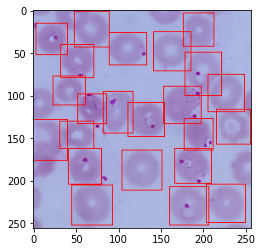

In [52]:
img = cv2.imread(imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]], cv2.IMREAD_COLOR)
list_bbxs = dict_bbxs[imgs_name[max(max_parasitized.items(), key=operator.itemgetter(1))[0]]]
img_with_box = bbv.draw_multiple_rectangles(img, [box.tolist()[:4] for box in list_bbxs], bbox_color = (255, 0, 0), thickness=1)
plt.imshow(img_with_box)

In [53]:
with open('imgs_name.pickle', 'wb') as handle:
    pickle.dump(imgs_name, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('true_boxes.pickle', 'wb') as handle:
    pickle.dump(true_boxes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('dict_bbxs.pickle', 'wb') as handle:
    pickle.dump(dict_bbxs, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Polygon to rectangle

In [54]:
filename =  'IMG_20150621_112043'
df_file = df[df['filename'] == filename]
df_file['position'].iloc[-1]

[(4166, 1704),
 (4176, 1688),
 (4184, 1664),
 (4195, 1647),
 (4230, 1633),
 (4272, 1631),
 (4309, 1644),
 (4342, 1679),
 (4341, 1709),
 (4326, 1733),
 (4299, 1758),
 (4265, 1758),
 (4233, 1750),
 (4204, 1735),
 (4174, 1718),
 (4162, 1714)]

In [55]:
rect = df_file['bbx']

In [56]:
df_file['bbx'].tolist()

[[3575, 1304, 3727, 1432],
 [1441, 1202, 1568, 1307],
 [2856, 1398, 2960, 1541],
 [2982, 1460, 3091, 1578],
 [3043, 1651, 3169, 1788],
 [2170, 1937, 2341, 2050],
 [2073, 1836, 2218, 1965],
 [1900, 1873, 2026, 1978],
 [1942, 2102, 2059, 2227],
 [1662, 1906, 1798, 2017],
 [1555, 1781, 1680, 1936],
 [1836, 1731, 2003, 1868],
 [2180, 1712, 2317, 1838],
 [2037, 1745, 2183, 1828],
 [1972, 1613, 2122, 1762],
 [1758, 1743, 1863, 1879],
 [1631, 2139, 1762, 2279],
 [1676, 2264, 1812, 2381],
 [2105, 2169, 2248, 2266],
 [2171, 2075, 2309, 2190],
 [2314, 1846, 2472, 1983],
 [2492, 1789, 2629, 1917],
 [2443, 1567, 2564, 1682],
 [2269, 1504, 2403, 1653],
 [2104, 1636, 2228, 1738],
 [2105, 1531, 2260, 1640],
 [2005, 1454, 2120, 1564],
 [1878, 1525, 2013, 1638],
 [1779, 1612, 1903, 1723],
 [1626, 1601, 1764, 1747],
 [1681, 1476, 1829, 1601],
 [1690, 1362, 1828, 1490],
 [1783, 1320, 1913, 1467],
 [1839, 1280, 1987, 1420],
 [1965, 1267, 2104, 1410],
 [2130, 1385, 2286, 1518],
 [2259, 1309, 2388, 1429],
 

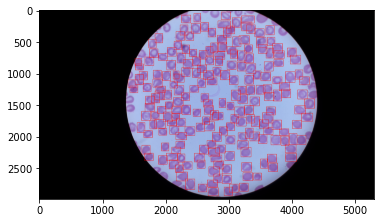

In [57]:
img = cv2.imread(df_file['img_path'].iloc[-1], cv2.IMREAD_COLOR)
img_with_box = bbv.draw_multiple_rectangles(img, df_file['bbx'].tolist(), bbox_color = (255, 0, 0), thickness=3)
plt.imshow(img_with_box)